# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Reshape, Dropout, UpSampling2D, MaxPooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer

# Dataset Load

We download MNIST dataset, consisting of 60.000 images of 28x28 pixels resolution. Each image defines a handwritten number in greyscale.

11490434/11490434 [==============================] - 0s 0us/step


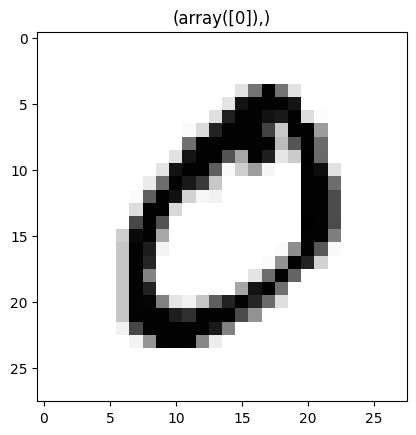

(60000, 28, 28)


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

y_train = LabelBinarizer().fit_transform(y_train)
y_test = LabelBinarizer().fit_transform(y_test)

plt.imshow(X_train[1], cmap = 'Greys')
plt.title(np.where(y_train[1]==1))
plt.show()
print(X_train.shape)

## Preprocessing data

The pixels in the source image are within the range [0, 256] we will normalize this range to [-1, 1] in order to treat this information with neural networks.

In [3]:
X_train = X_train.astype('float32')/127.5 -1

X_train = np.expand_dims(X_train, axis=3)

# Generator definition

In [4]:
def create_generator():
    input_z = Input(shape=(100))

    # Introducir una nueva entrada input_label y concatenerla con input_z para formar la entrada de la red
    input_label = Input(shape=(10))
    x = Concatenate()([input_z, input_label])

    # Cambiar el modelo para que ahora admita las dos entradas
    x = Dense(7*7*128)(x)
    x = Reshape((7,7,128))(x)

    x = UpSampling2D()(x)
    x = Conv2D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding='same')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Activation('relu')(x)

    x = Conv2D(1, kernel_size=3, padding='same')(x)
    output = Activation('tanh')(x)

    generator = Model([input_z,input_label], output)

    return generator

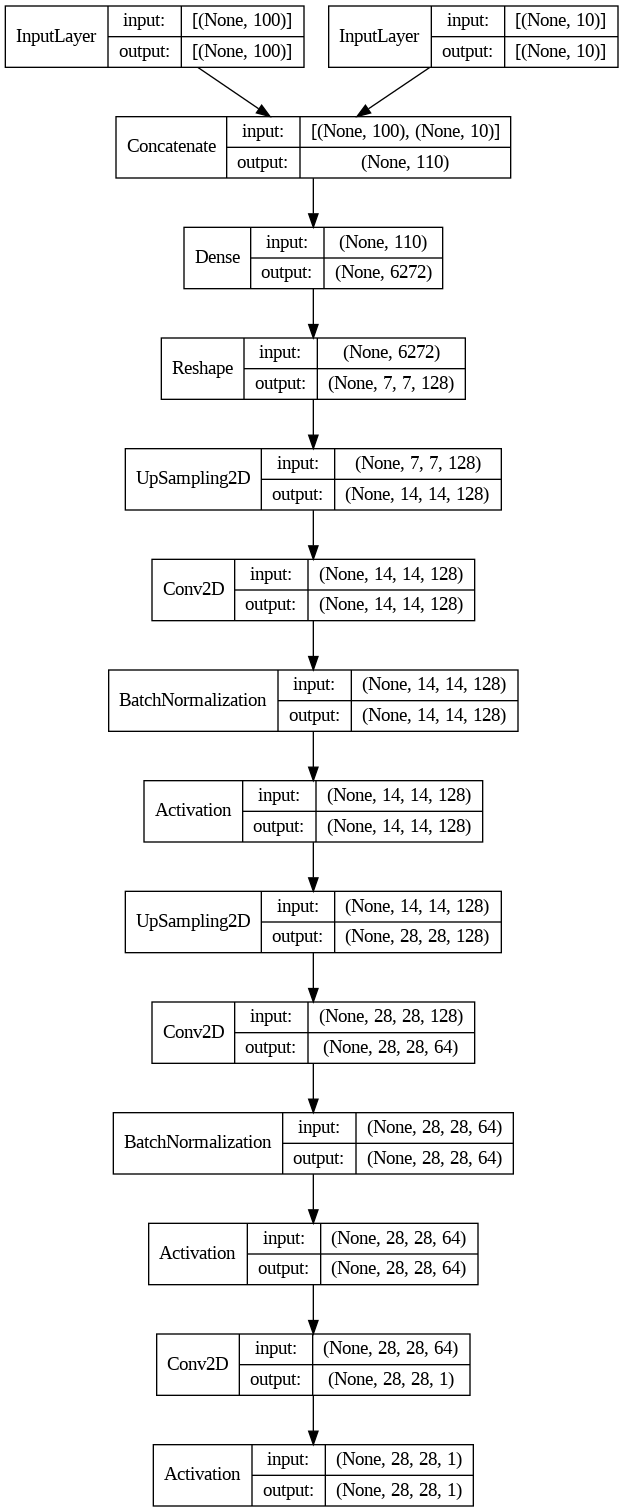

In [5]:
generator = create_generator()
plot_model(generator, show_shapes=True, show_layer_names=False)

# Discriminator definition

In [6]:
def create_discriminator():
    input = Input(shape=(28, 28, 1))

    # Introducir una nueva salida output_label que clasifique la etiqueta de las imágenes

    # Cambiar el modelo para que ahora genere dos salidas
    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(input)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    input_label = Input(shape=(10))
    merged = Concatenate()([x, input_label])

    output_validity = Dense(1, activation='sigmoid')(x)
    output_label = Dense(10, activation='softmax')(merged)

    discriminator = Model([input, input_label], [output_validity, output_label])

    return discriminator

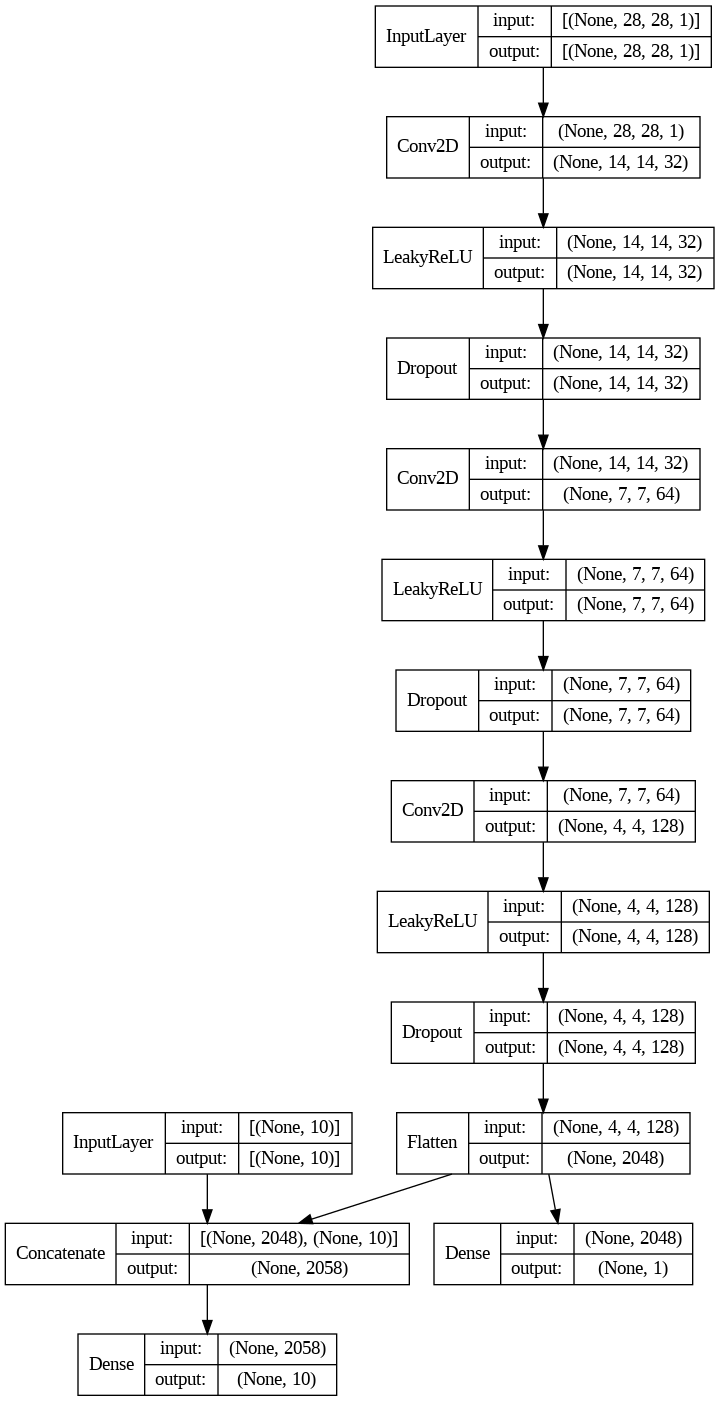

In [7]:
discriminator = create_discriminator()
plot_model(discriminator, show_shapes=True, show_layer_names=False)

# GAN model definition

In [8]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])
discriminator.trainable = False

z = Input(shape=(100,))
# Crear una nueva entrada label que tenga tantas dimensiones como clases
label = Input(shape=(10,))

# Introducir al generador las entradas z y label al mismo tiempo
img = generator([z, label])

# Obtener del discriminador las salidas validity y target_label a la vez
validity, target_label = discriminator([img, label])

# Modificar combined para que el modelo admita ambas entradas y salidas
combined = Model([z, label], [validity, target_label])
# Compilar el modelo para que ahora tenga 2 funciones de pérdida:
    # binary_crossentropy: para la salida de validez
    # categorical_crossentropy: para la salida de clasificación de etiqueta
combined.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=Adam(learning_rate=0.0001))

# Training

In [9]:
def generate_random_labels(batch_size, array_length):
    batch = []
    for _ in range(batch_size):
        arr = np.zeros(array_length)

        random_position = random.randint(0, array_length - 1)
        arr[random_position] = 1

        batch.append(arr)

    return np.array(batch)

In [10]:
def train(X_train, y_train, generator, discriminator, combined, epochs, batch_size=32, sample_interval=100):
    # Adversarial ground truths (-1 fake and 1 real)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    history = {
        'd_loss' : [],
        'd_acc' : [],
        'g_loss' : []
    }

    for epoch in range(epochs):
        print("----EPOCH " + str(epoch) + '-----')
        for batch in range(int(len(X_train)/batch_size)):
            #  Train the Discriminator
            noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            gen_labels = generate_random_labels(batch_size=batch_size, array_length=10)

            # El generador ahora deberá admitir el noise la mismo tiempo que los gen_labels generados aleatoriamente
            gen_imgs = generator.predict([noise, gen_labels], verbose=0)

            imgs = X_train[batch*batch_size : (batch+1)*batch_size]
            # Obtener el batch correspondiente de etiquetas de y_train
            img_labels = y_train[batch*batch_size : (batch+1)*batch_size]

            # Añadir a las salidas deseadas del discriminador las etiquetas aleatorias y las obtenidas de y_train
            d_loss_real = discriminator.train_on_batch([imgs, img_labels], [valid, img_labels])
            d_loss_fake = discriminator.train_on_batch([gen_imgs, gen_labels], [fake, gen_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the Generator
            # noise = np.random.normal(0, 1, (batch_size, 100))
            # Generar un batch de etiquetas de manera aleatoria
            # gen_labels = generate_random_labels(batch_size=batch_size, array_length=10)

            # Añadir como entrada y salida las etiquetas generadas
            g_loss = combined.train_on_batch([noise, gen_labels], [valid, gen_labels])

            # Save losses
            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[3])
            history['g_loss'].append(g_loss)

            # Plot the progress
            if batch % 50 == 0:
                print ("%d [D loss: %.4f,\t acc.: %.2f%%]\t[G loss: %.4f]" % (batch, d_loss[0], 100*d_loss[3], g_loss[0]))

            if batch % 500 == 0:
                sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels)

        plot_losses(history)

## Plotting functions

In [11]:
def sample_images(epoch, batch, gen_imgs, gen_labels, imgs, img_labels):
    plt.rcParams['figure.figsize'] = [15, 5]
    fig, axs = plt.subplots(2, 5)
    fig.suptitle('Epoch: ' + str(epoch) + ', Batch: ' + str(batch), fontsize=16)
    for i in range(5):
        axs[0,i].imshow(gen_imgs[i,:,:,0], cmap='Greys')
        axs[0,i].set_title(np.where(gen_labels[i]==1))
        axs[0,i].axis('off')

    for i in range(5):
        axs[1,i].imshow(imgs[i,:,:,0], cmap='Greys')
        axs[1,i].set_title(np.where(img_labels[i]==1))
        axs[1,i].axis('off')
    plt.show()
    plt.close()

In [12]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()

    ax1.plot(history['d_loss'], label='D loss')
    ax1.plot(history['g_loss'], label='G loss')
    ax1.legend()

    ax2.set_title('D accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend(loc="upper right")
    ax2.grid()

    ax2.plot(history['d_acc'], label='Accuracy')
    ax2.legend()

    plt.show()

----EPOCH 0-----
0 [D loss: 1.3800,	 acc.: 42.19%]	[G loss: 2.9757]


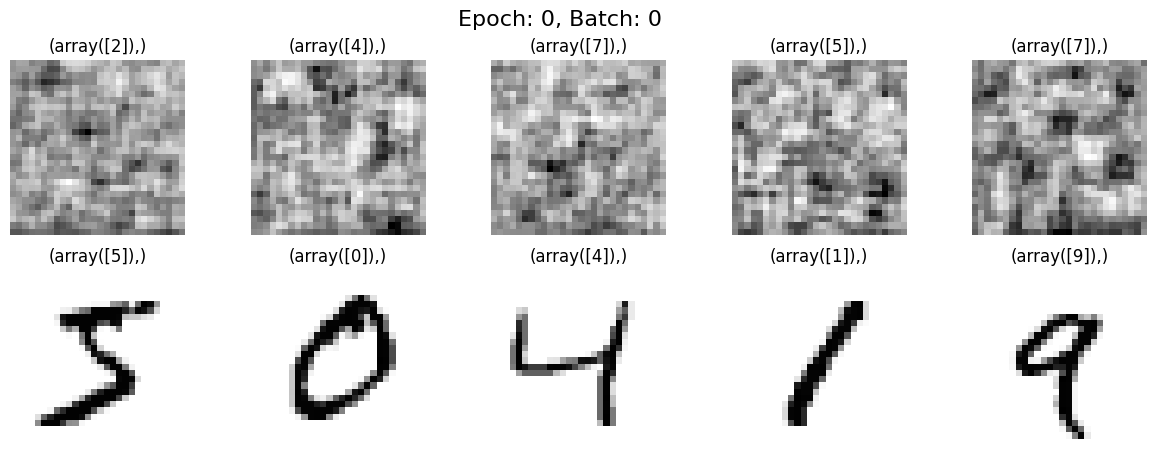

50 [D loss: 0.9666,	 acc.: 56.25%]	[G loss: 2.9720]
100 [D loss: 1.0208,	 acc.: 43.75%]	[G loss: 2.9637]
150 [D loss: 1.0241,	 acc.: 45.31%]	[G loss: 2.8336]
200 [D loss: 0.9944,	 acc.: 54.69%]	[G loss: 2.7427]
250 [D loss: 0.9872,	 acc.: 50.00%]	[G loss: 2.6056]
300 [D loss: 0.8624,	 acc.: 73.44%]	[G loss: 2.1767]
350 [D loss: 0.7882,	 acc.: 76.56%]	[G loss: 1.4045]
400 [D loss: 0.7471,	 acc.: 78.12%]	[G loss: 1.1862]
450 [D loss: 0.8203,	 acc.: 60.94%]	[G loss: 0.9707]
500 [D loss: 0.8203,	 acc.: 51.56%]	[G loss: 0.8577]


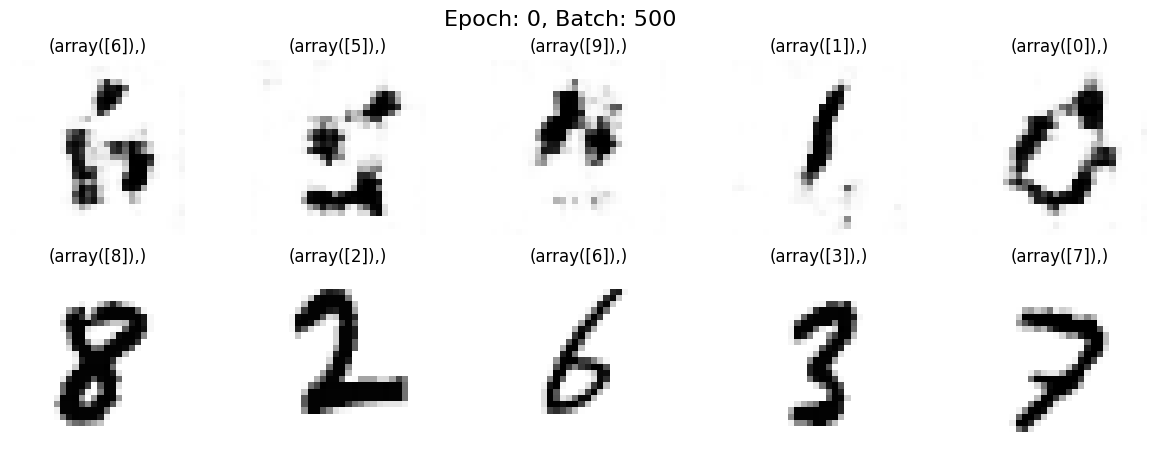

550 [D loss: 0.8469,	 acc.: 51.56%]	[G loss: 0.9038]
600 [D loss: 0.9439,	 acc.: 39.06%]	[G loss: 0.7973]
650 [D loss: 0.8581,	 acc.: 39.06%]	[G loss: 0.7443]
700 [D loss: 0.8028,	 acc.: 51.56%]	[G loss: 0.7817]
750 [D loss: 0.7962,	 acc.: 45.31%]	[G loss: 0.8147]
800 [D loss: 0.8209,	 acc.: 51.56%]	[G loss: 0.7675]
850 [D loss: 0.7992,	 acc.: 51.56%]	[G loss: 0.7593]
900 [D loss: 0.7600,	 acc.: 51.56%]	[G loss: 0.7321]
950 [D loss: 0.8575,	 acc.: 29.69%]	[G loss: 0.7546]
1000 [D loss: 0.8146,	 acc.: 51.56%]	[G loss: 0.7224]


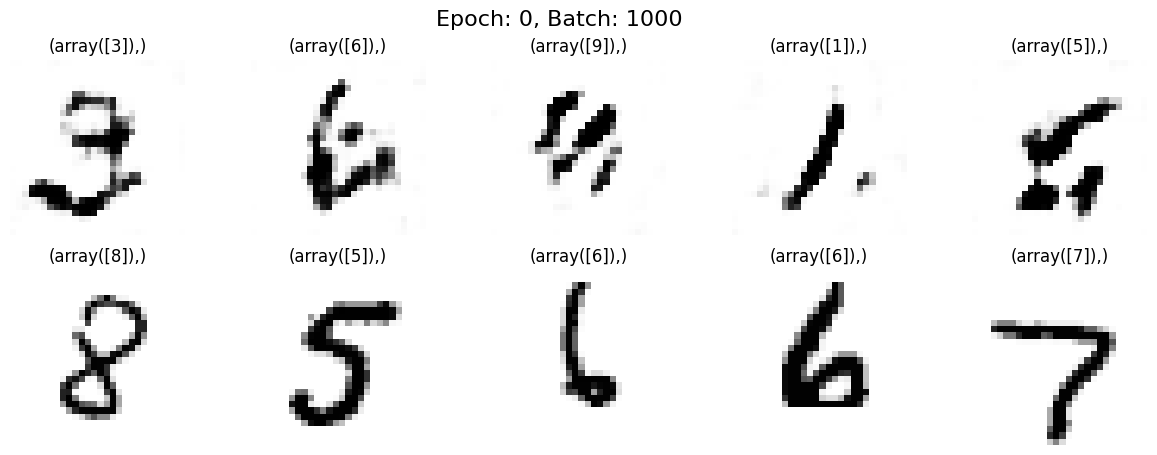

1050 [D loss: 0.8111,	 acc.: 50.00%]	[G loss: 0.7407]
1100 [D loss: 0.7887,	 acc.: 51.56%]	[G loss: 0.6973]
1150 [D loss: 0.8101,	 acc.: 45.31%]	[G loss: 0.7223]
1200 [D loss: 0.7892,	 acc.: 62.50%]	[G loss: 0.7078]
1250 [D loss: 0.7920,	 acc.: 50.00%]	[G loss: 0.7327]
1300 [D loss: 0.7728,	 acc.: 57.81%]	[G loss: 0.8580]
1350 [D loss: 0.8000,	 acc.: 43.75%]	[G loss: 0.7429]
1400 [D loss: 0.7631,	 acc.: 56.25%]	[G loss: 0.7434]
1450 [D loss: 0.7955,	 acc.: 48.44%]	[G loss: 0.7709]
1500 [D loss: 0.7457,	 acc.: 53.12%]	[G loss: 0.7101]


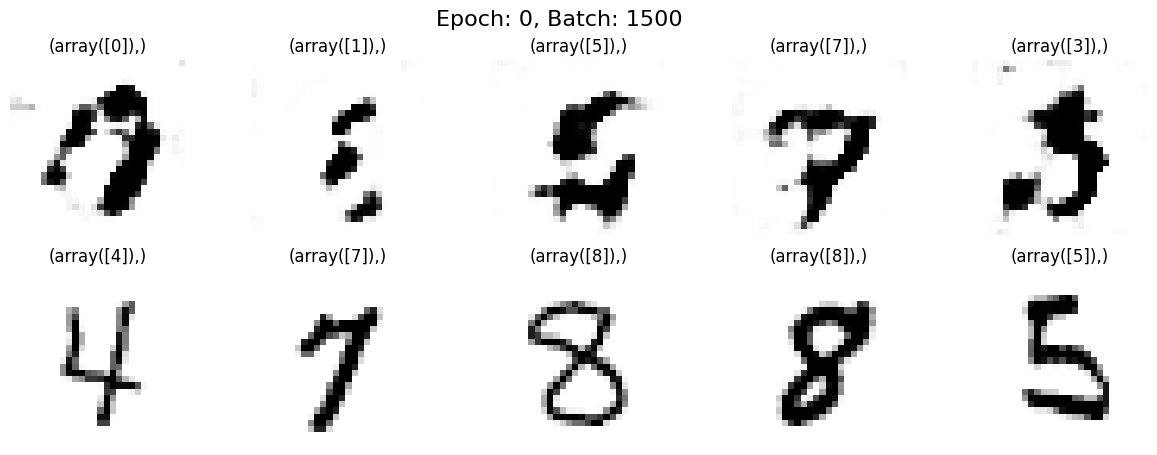

1550 [D loss: 0.8197,	 acc.: 45.31%]	[G loss: 0.7779]
1600 [D loss: 0.7776,	 acc.: 56.25%]	[G loss: 0.7820]
1650 [D loss: 0.7913,	 acc.: 50.00%]	[G loss: 0.6940]
1700 [D loss: 0.7243,	 acc.: 56.25%]	[G loss: 0.7969]
1750 [D loss: 0.7653,	 acc.: 50.00%]	[G loss: 0.6821]
1800 [D loss: 0.7883,	 acc.: 46.88%]	[G loss: 0.6842]
1850 [D loss: 0.7024,	 acc.: 62.50%]	[G loss: 0.7941]


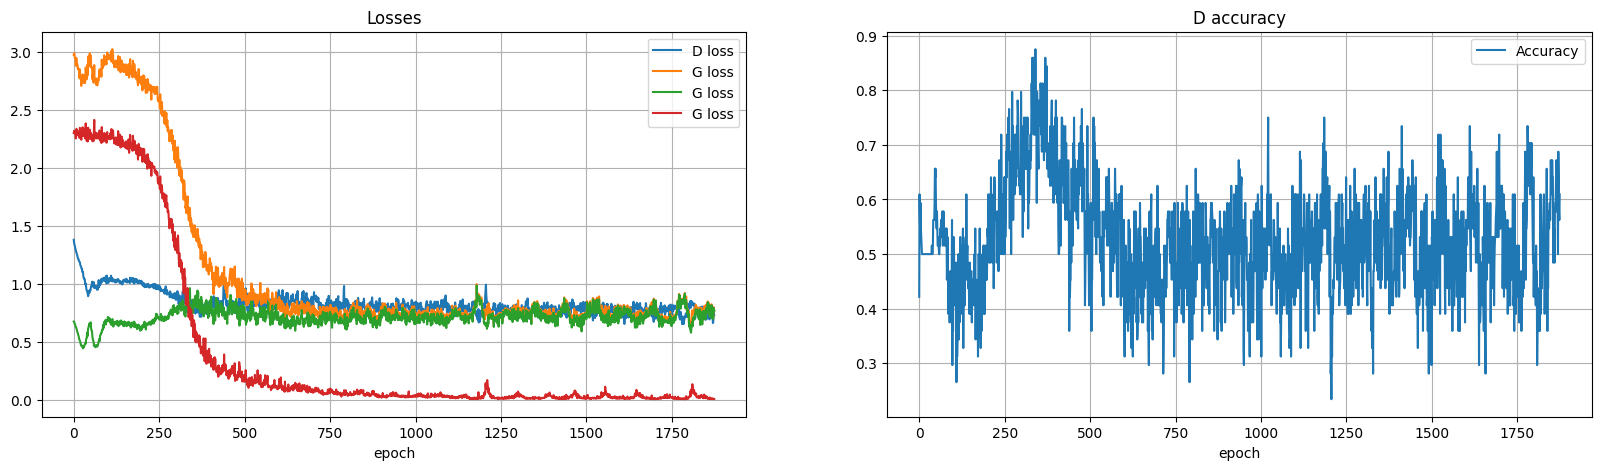

----EPOCH 1-----
0 [D loss: 0.7113,	 acc.: 60.94%]	[G loss: 0.7513]


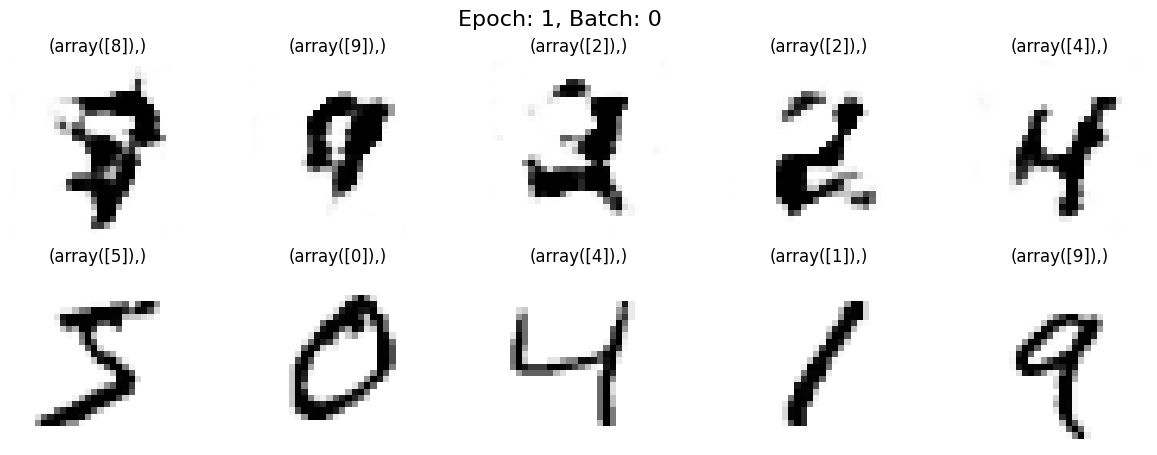

50 [D loss: 0.8425,	 acc.: 31.25%]	[G loss: 0.7605]
100 [D loss: 0.7694,	 acc.: 51.56%]	[G loss: 0.7008]
150 [D loss: 0.6888,	 acc.: 68.75%]	[G loss: 0.7701]
200 [D loss: 0.7991,	 acc.: 40.62%]	[G loss: 0.6307]
250 [D loss: 0.9537,	 acc.: 26.56%]	[G loss: 0.6524]
300 [D loss: 0.8713,	 acc.: 26.56%]	[G loss: 0.6766]
350 [D loss: 0.7136,	 acc.: 65.62%]	[G loss: 0.7841]
400 [D loss: 0.8261,	 acc.: 31.25%]	[G loss: 0.6210]
450 [D loss: 0.7045,	 acc.: 60.94%]	[G loss: 0.8968]
500 [D loss: 0.8358,	 acc.: 39.06%]	[G loss: 0.7443]


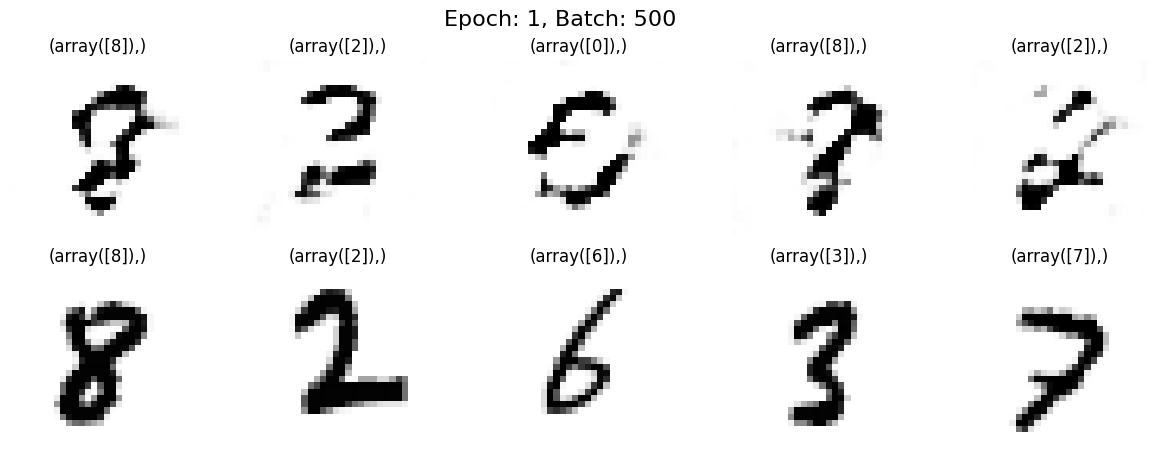

550 [D loss: 0.6975,	 acc.: 70.31%]	[G loss: 0.8400]
600 [D loss: 0.8316,	 acc.: 39.06%]	[G loss: 0.6927]
650 [D loss: 0.8093,	 acc.: 42.19%]	[G loss: 0.7803]
700 [D loss: 0.7466,	 acc.: 51.56%]	[G loss: 0.7378]
750 [D loss: 0.7118,	 acc.: 57.81%]	[G loss: 0.7037]
800 [D loss: 0.7619,	 acc.: 51.56%]	[G loss: 0.7376]
850 [D loss: 0.8152,	 acc.: 43.75%]	[G loss: 0.7808]
900 [D loss: 0.7703,	 acc.: 43.75%]	[G loss: 0.6810]
950 [D loss: 0.7631,	 acc.: 56.25%]	[G loss: 0.7935]
1000 [D loss: 0.7041,	 acc.: 64.06%]	[G loss: 0.7252]


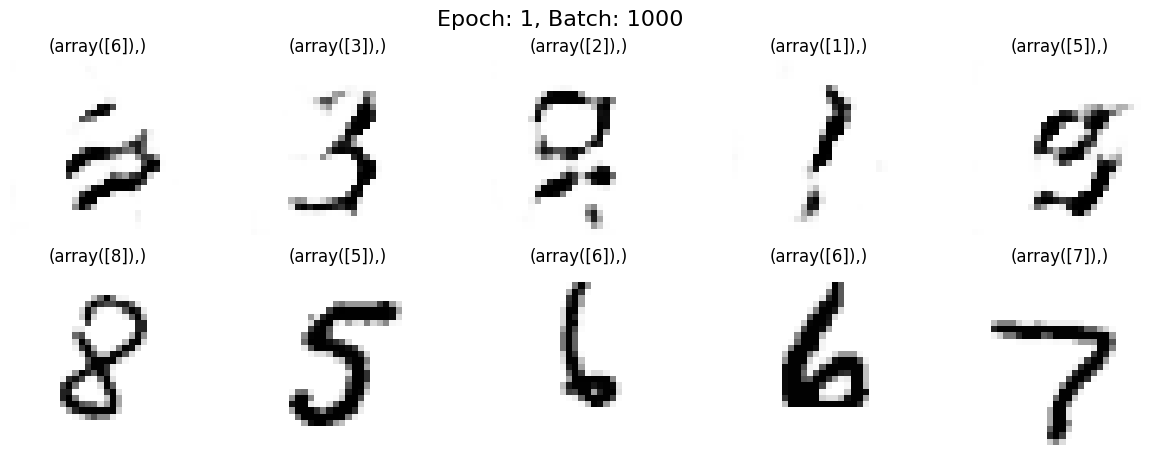

1050 [D loss: 0.7490,	 acc.: 50.00%]	[G loss: 0.7418]
1100 [D loss: 0.7132,	 acc.: 70.31%]	[G loss: 0.7692]
1150 [D loss: 0.7667,	 acc.: 50.00%]	[G loss: 0.6290]
1200 [D loss: 0.7193,	 acc.: 57.81%]	[G loss: 0.8353]
1250 [D loss: 0.6952,	 acc.: 68.75%]	[G loss: 0.7701]
1300 [D loss: 0.8585,	 acc.: 28.12%]	[G loss: 0.7359]
1350 [D loss: 0.6691,	 acc.: 79.69%]	[G loss: 0.8469]
1400 [D loss: 0.7526,	 acc.: 51.56%]	[G loss: 0.7001]
1450 [D loss: 0.7587,	 acc.: 46.88%]	[G loss: 0.8638]
1500 [D loss: 0.6937,	 acc.: 67.19%]	[G loss: 0.7482]


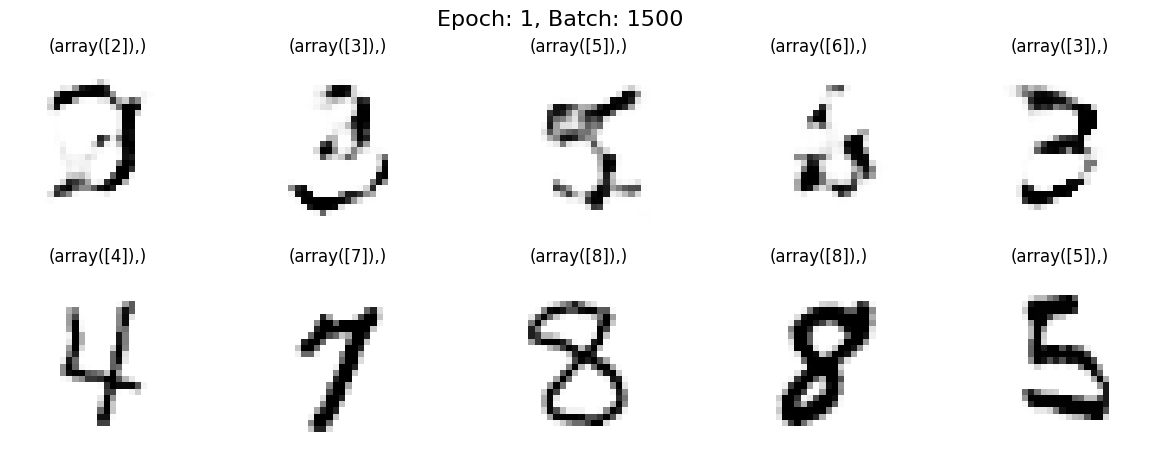

1550 [D loss: 0.8369,	 acc.: 34.38%]	[G loss: 0.6550]
1600 [D loss: 0.7153,	 acc.: 60.94%]	[G loss: 0.7717]
1650 [D loss: 0.7454,	 acc.: 57.81%]	[G loss: 0.6852]
1700 [D loss: 0.7568,	 acc.: 45.31%]	[G loss: 0.7645]
1750 [D loss: 0.7003,	 acc.: 62.50%]	[G loss: 0.7702]
1800 [D loss: 0.7692,	 acc.: 46.88%]	[G loss: 0.7304]
1850 [D loss: 0.7315,	 acc.: 46.88%]	[G loss: 0.7552]


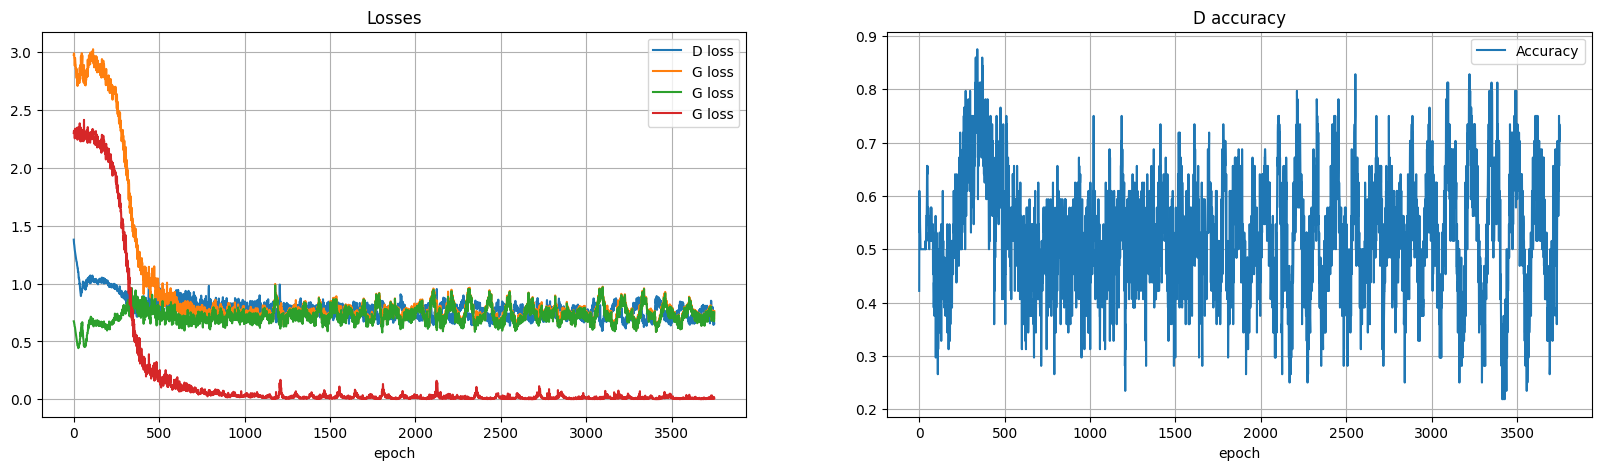

----EPOCH 2-----
0 [D loss: 0.6808,	 acc.: 67.19%]	[G loss: 0.7271]


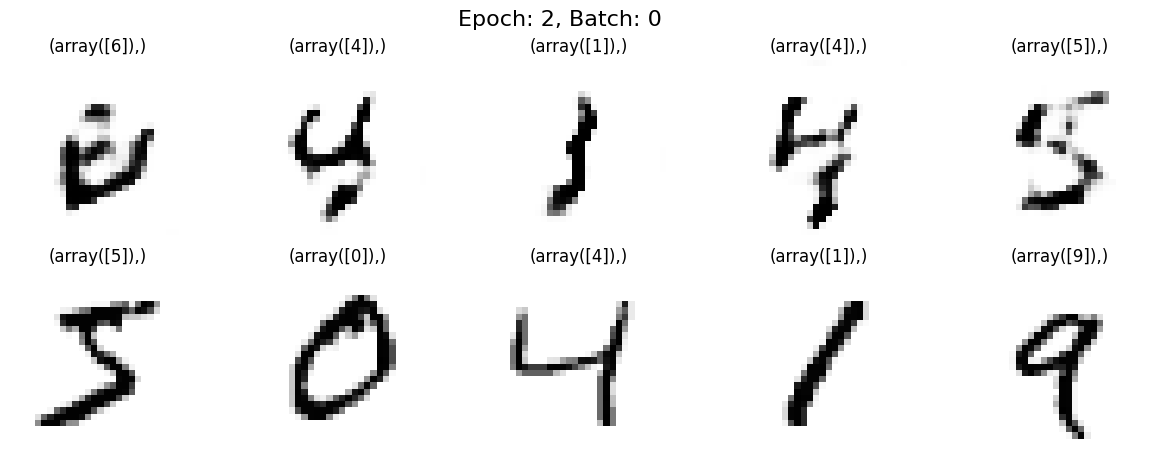

50 [D loss: 0.7684,	 acc.: 43.75%]	[G loss: 0.6458]
100 [D loss: 0.7517,	 acc.: 45.31%]	[G loss: 0.7878]
150 [D loss: 0.6664,	 acc.: 71.88%]	[G loss: 0.7559]
200 [D loss: 0.8235,	 acc.: 35.94%]	[G loss: 0.6619]
250 [D loss: 0.8550,	 acc.: 40.62%]	[G loss: 0.7181]
300 [D loss: 0.7260,	 acc.: 56.25%]	[G loss: 0.6844]
350 [D loss: 0.7460,	 acc.: 53.12%]	[G loss: 0.7659]
400 [D loss: 0.7061,	 acc.: 62.50%]	[G loss: 0.7327]
450 [D loss: 0.7766,	 acc.: 45.31%]	[G loss: 0.6754]
500 [D loss: 0.7324,	 acc.: 60.94%]	[G loss: 0.7514]


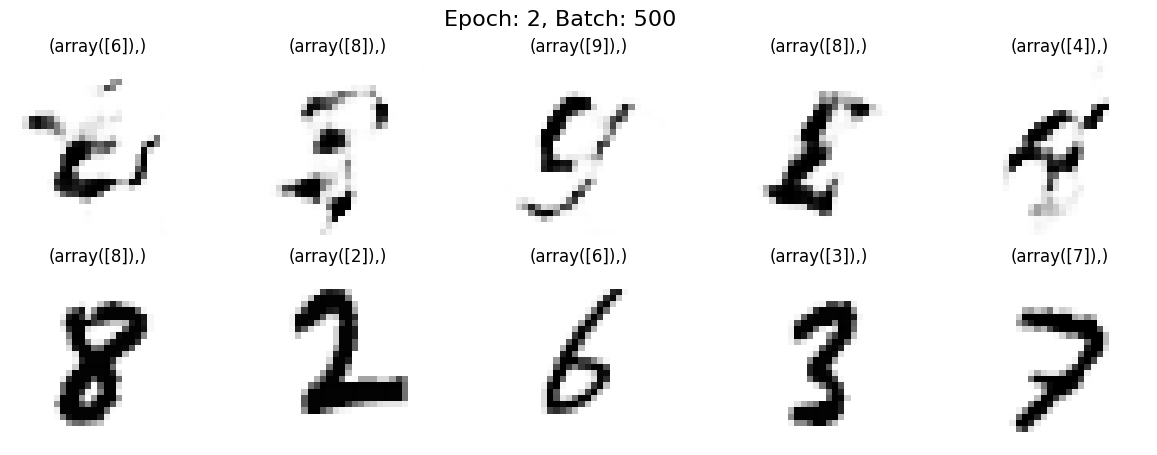

550 [D loss: 0.7541,	 acc.: 48.44%]	[G loss: 0.6891]
600 [D loss: 0.7859,	 acc.: 54.69%]	[G loss: 0.7864]
650 [D loss: 0.7553,	 acc.: 42.19%]	[G loss: 0.7240]
700 [D loss: 0.6992,	 acc.: 62.50%]	[G loss: 0.7816]
750 [D loss: 0.6845,	 acc.: 65.62%]	[G loss: 0.7637]
800 [D loss: 0.7301,	 acc.: 62.50%]	[G loss: 0.6792]
850 [D loss: 0.7010,	 acc.: 60.94%]	[G loss: 0.7488]
900 [D loss: 0.7859,	 acc.: 37.50%]	[G loss: 0.6378]
950 [D loss: 0.7512,	 acc.: 43.75%]	[G loss: 0.7978]
1000 [D loss: 0.7230,	 acc.: 60.94%]	[G loss: 0.7154]


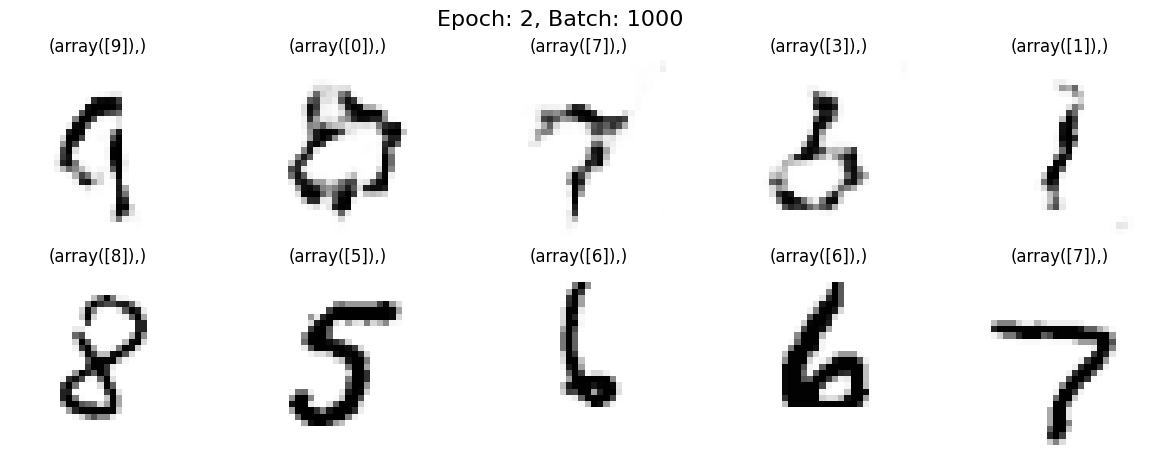

1050 [D loss: 0.7406,	 acc.: 43.75%]	[G loss: 0.8281]
1100 [D loss: 0.6721,	 acc.: 65.62%]	[G loss: 0.8065]
1150 [D loss: 0.8373,	 acc.: 32.81%]	[G loss: 0.6298]
1200 [D loss: 0.7707,	 acc.: 40.62%]	[G loss: 0.6729]
1250 [D loss: 0.7260,	 acc.: 59.38%]	[G loss: 0.6994]
1300 [D loss: 0.7578,	 acc.: 56.25%]	[G loss: 0.7595]
1350 [D loss: 0.6476,	 acc.: 79.69%]	[G loss: 0.8363]
1400 [D loss: 0.7377,	 acc.: 45.31%]	[G loss: 0.7358]
1450 [D loss: 0.7447,	 acc.: 50.00%]	[G loss: 0.7192]
1500 [D loss: 0.6924,	 acc.: 60.94%]	[G loss: 0.7315]


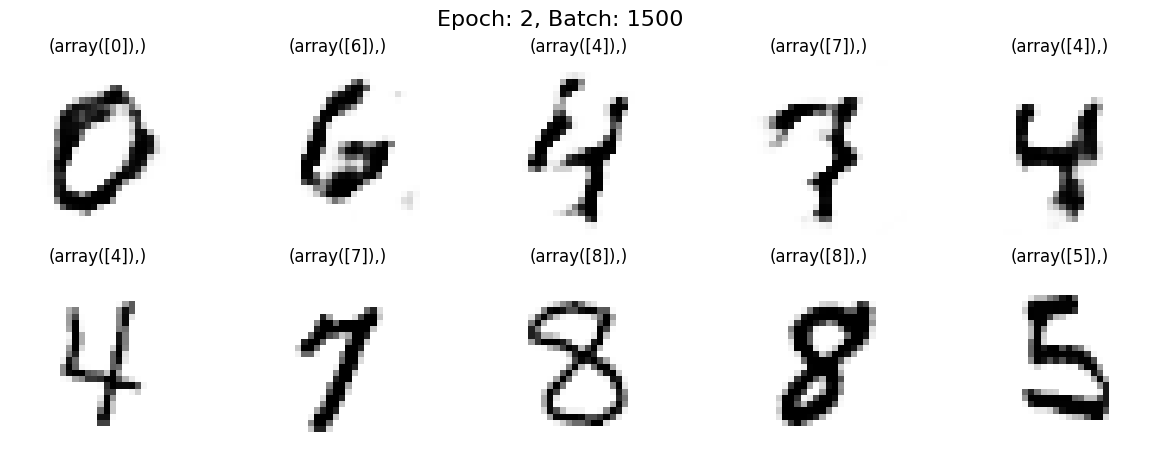

1550 [D loss: 0.7048,	 acc.: 59.38%]	[G loss: 0.7680]
1600 [D loss: 0.6769,	 acc.: 70.31%]	[G loss: 0.7685]
1650 [D loss: 0.7712,	 acc.: 42.19%]	[G loss: 0.6576]
1700 [D loss: 0.7586,	 acc.: 48.44%]	[G loss: 0.7667]
1750 [D loss: 0.6824,	 acc.: 62.50%]	[G loss: 0.7095]
1800 [D loss: 0.7370,	 acc.: 42.19%]	[G loss: 0.6937]
1850 [D loss: 0.6454,	 acc.: 73.44%]	[G loss: 0.7906]


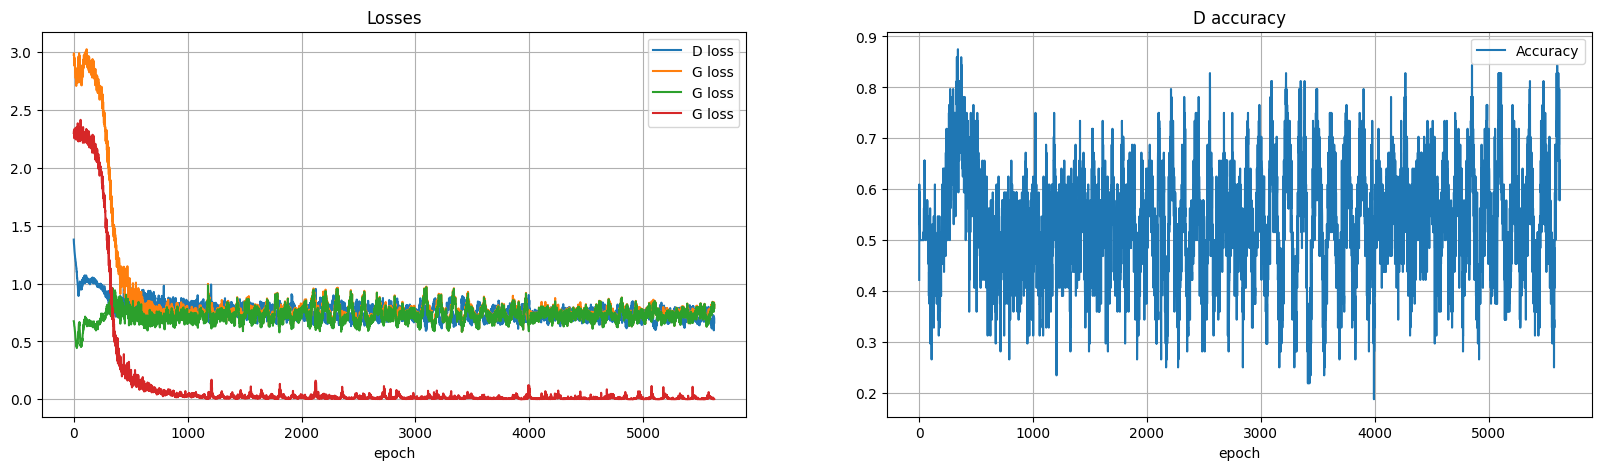

----EPOCH 3-----
0 [D loss: 0.6675,	 acc.: 70.31%]	[G loss: 0.8233]


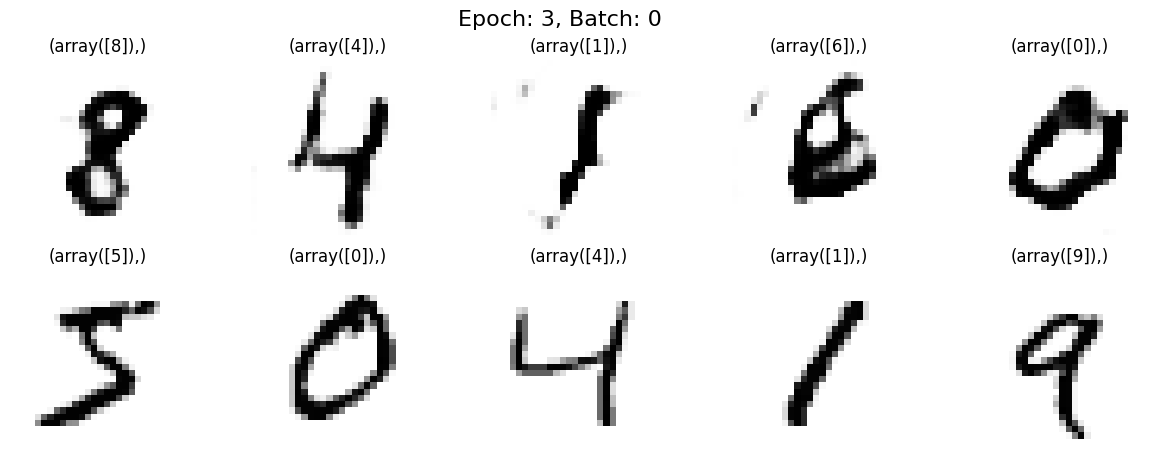

50 [D loss: 0.7475,	 acc.: 53.12%]	[G loss: 0.6931]
100 [D loss: 0.7307,	 acc.: 50.00%]	[G loss: 0.7154]
150 [D loss: 0.6801,	 acc.: 67.19%]	[G loss: 0.7666]
200 [D loss: 0.7707,	 acc.: 39.06%]	[G loss: 0.7421]
250 [D loss: 0.6980,	 acc.: 65.62%]	[G loss: 0.7242]
300 [D loss: 0.6732,	 acc.: 65.62%]	[G loss: 0.7771]
350 [D loss: 0.7583,	 acc.: 53.12%]	[G loss: 0.7331]
400 [D loss: 0.6719,	 acc.: 64.06%]	[G loss: 0.7817]
450 [D loss: 0.7108,	 acc.: 54.69%]	[G loss: 0.8182]
500 [D loss: 0.8565,	 acc.: 34.38%]	[G loss: 0.6861]


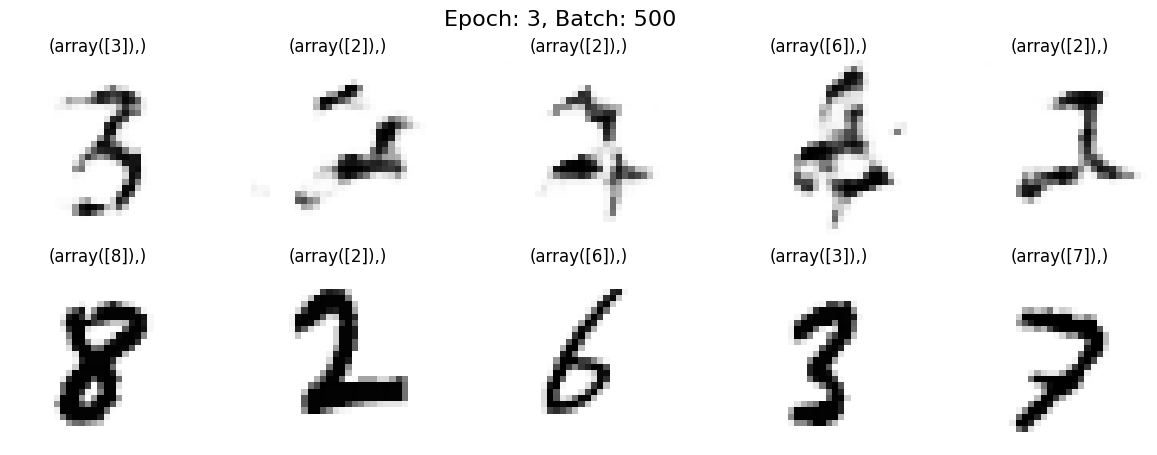

550 [D loss: 0.7065,	 acc.: 59.38%]	[G loss: 0.7653]
600 [D loss: 0.7798,	 acc.: 37.50%]	[G loss: 0.7671]
650 [D loss: 0.7324,	 acc.: 54.69%]	[G loss: 0.7191]
700 [D loss: 0.6868,	 acc.: 60.94%]	[G loss: 0.7679]
750 [D loss: 0.7106,	 acc.: 45.31%]	[G loss: 0.7432]
800 [D loss: 0.7111,	 acc.: 50.00%]	[G loss: 0.7447]
850 [D loss: 0.6748,	 acc.: 60.94%]	[G loss: 0.7270]
900 [D loss: 0.7369,	 acc.: 51.56%]	[G loss: 0.6596]
950 [D loss: 0.8026,	 acc.: 45.31%]	[G loss: 0.7244]
1000 [D loss: 0.7038,	 acc.: 60.94%]	[G loss: 0.7246]


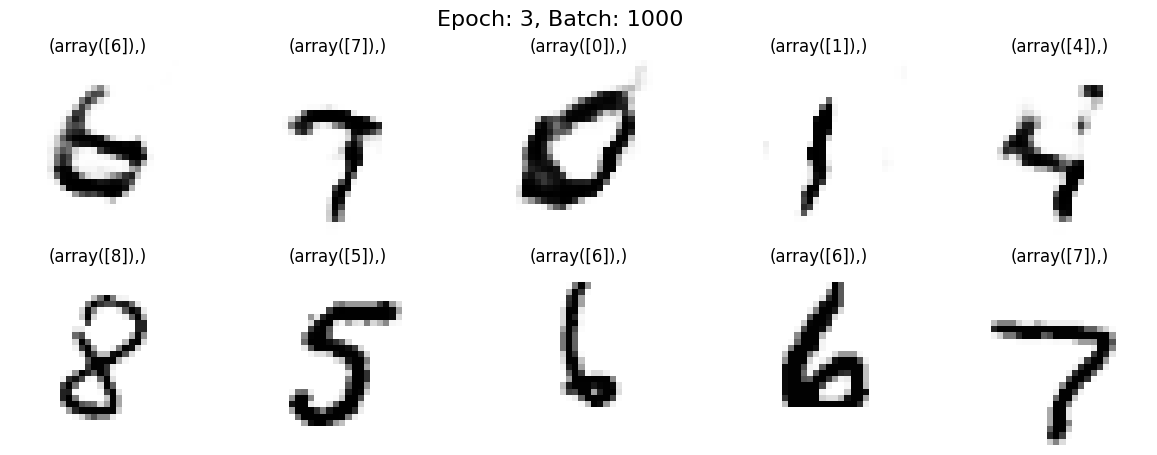

1050 [D loss: 0.6983,	 acc.: 53.12%]	[G loss: 0.7692]
1100 [D loss: 0.7166,	 acc.: 54.69%]	[G loss: 0.7346]
1150 [D loss: 0.7109,	 acc.: 56.25%]	[G loss: 0.7925]
1200 [D loss: 0.7354,	 acc.: 56.25%]	[G loss: 0.7324]
1250 [D loss: 0.7116,	 acc.: 57.81%]	[G loss: 0.7073]
1300 [D loss: 0.7280,	 acc.: 53.12%]	[G loss: 0.7690]
1350 [D loss: 0.7110,	 acc.: 67.19%]	[G loss: 0.7224]
1400 [D loss: 0.6698,	 acc.: 64.06%]	[G loss: 0.8267]
1450 [D loss: 0.7891,	 acc.: 37.50%]	[G loss: 0.6335]
1500 [D loss: 0.6951,	 acc.: 60.94%]	[G loss: 0.6727]


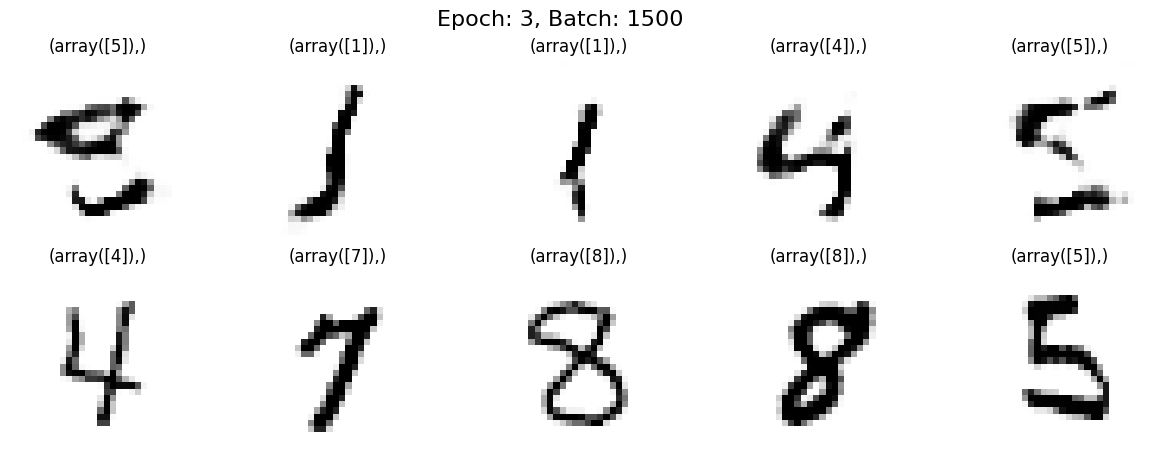

1550 [D loss: 0.6085,	 acc.: 73.44%]	[G loss: 0.9115]
1600 [D loss: 0.8320,	 acc.: 31.25%]	[G loss: 0.6006]
1650 [D loss: 0.7588,	 acc.: 45.31%]	[G loss: 0.7136]
1700 [D loss: 0.6992,	 acc.: 57.81%]	[G loss: 0.8086]
1750 [D loss: 0.7224,	 acc.: 51.56%]	[G loss: 0.7034]
1800 [D loss: 0.7097,	 acc.: 60.94%]	[G loss: 0.7795]
1850 [D loss: 0.7038,	 acc.: 60.94%]	[G loss: 0.7459]


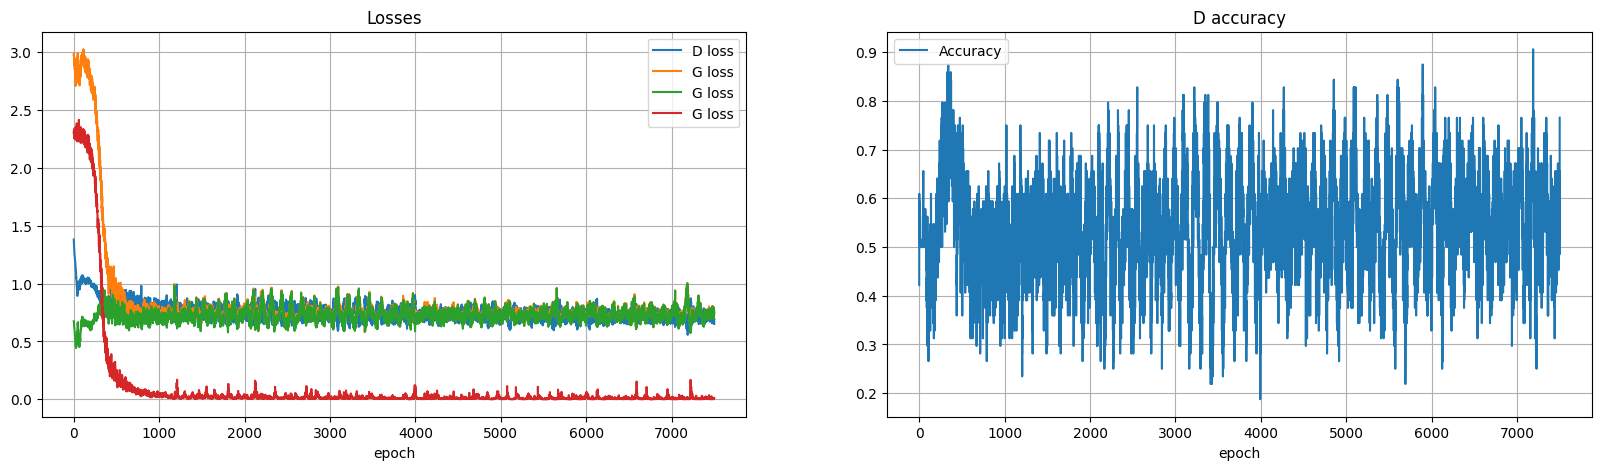

----EPOCH 4-----
0 [D loss: 0.7053,	 acc.: 57.81%]	[G loss: 0.7706]


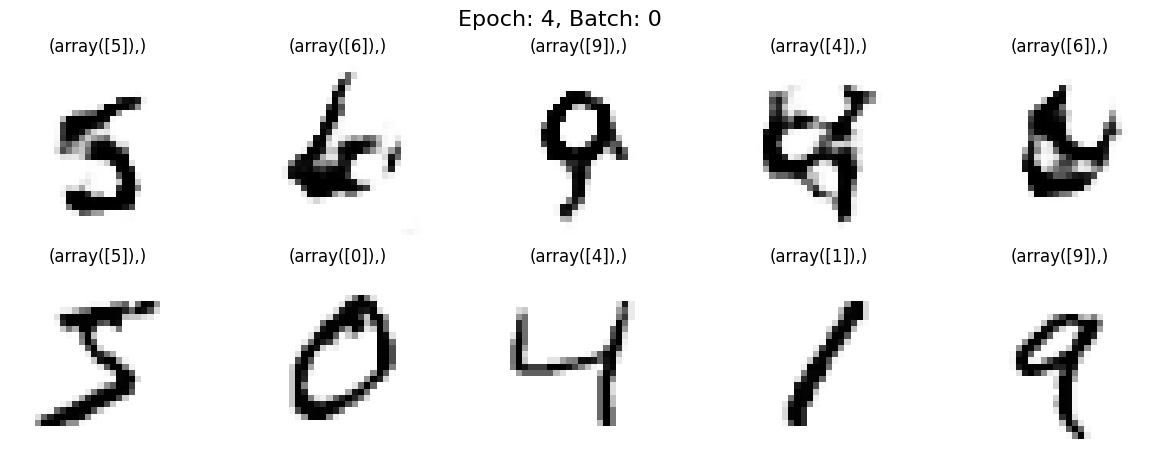

50 [D loss: 0.7308,	 acc.: 50.00%]	[G loss: 0.7324]
100 [D loss: 0.7304,	 acc.: 46.88%]	[G loss: 0.7499]
150 [D loss: 0.6700,	 acc.: 65.62%]	[G loss: 0.6985]
200 [D loss: 0.6725,	 acc.: 68.75%]	[G loss: 0.6864]
250 [D loss: 0.7051,	 acc.: 60.94%]	[G loss: 0.7973]
300 [D loss: 0.7030,	 acc.: 50.00%]	[G loss: 0.7156]
350 [D loss: 0.7196,	 acc.: 54.69%]	[G loss: 0.7056]
400 [D loss: 0.6830,	 acc.: 59.38%]	[G loss: 0.8059]
450 [D loss: 0.7163,	 acc.: 51.56%]	[G loss: 0.6864]
500 [D loss: 0.7221,	 acc.: 56.25%]	[G loss: 0.6831]


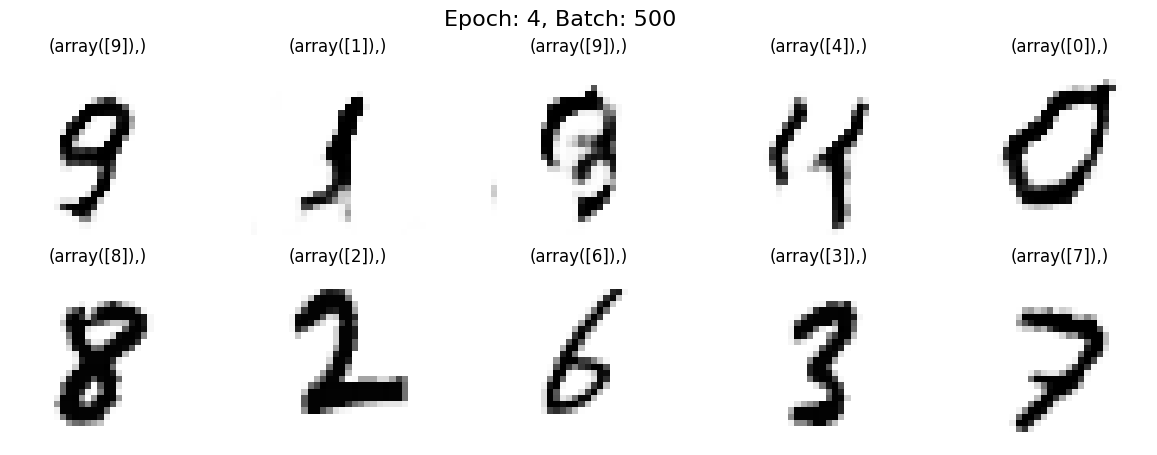

550 [D loss: 0.7072,	 acc.: 51.56%]	[G loss: 0.8239]
600 [D loss: 0.7437,	 acc.: 45.31%]	[G loss: 0.7464]
650 [D loss: 0.6679,	 acc.: 67.19%]	[G loss: 0.7955]
700 [D loss: 0.7358,	 acc.: 54.69%]	[G loss: 0.7525]
750 [D loss: 0.7254,	 acc.: 46.88%]	[G loss: 0.7250]
800 [D loss: 0.7276,	 acc.: 46.88%]	[G loss: 0.7230]
850 [D loss: 0.7594,	 acc.: 43.75%]	[G loss: 0.7005]
900 [D loss: 0.6828,	 acc.: 60.94%]	[G loss: 0.7104]
950 [D loss: 0.7131,	 acc.: 53.12%]	[G loss: 0.7378]
1000 [D loss: 0.7874,	 acc.: 42.19%]	[G loss: 0.6761]


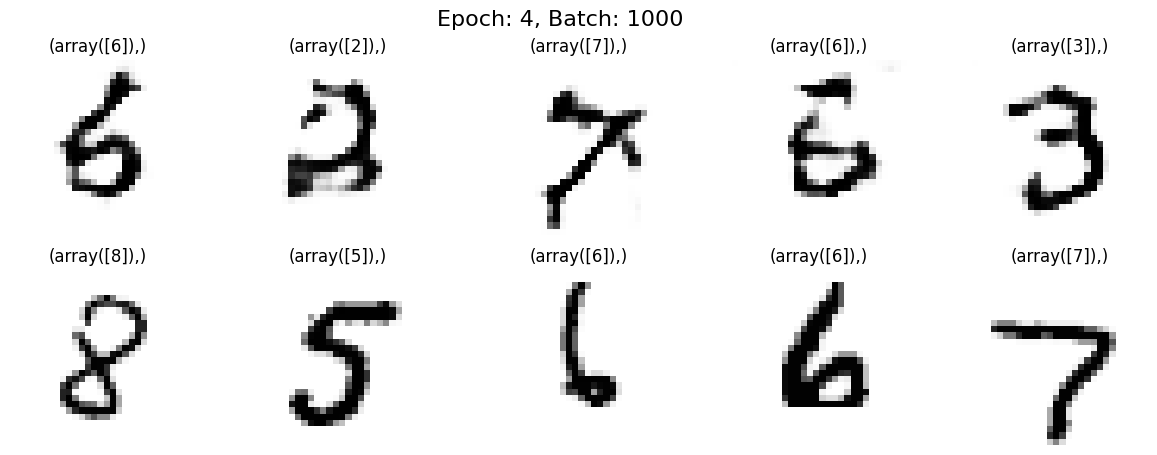

1050 [D loss: 0.7222,	 acc.: 48.44%]	[G loss: 0.7548]
1100 [D loss: 0.6798,	 acc.: 56.25%]	[G loss: 0.7588]
1150 [D loss: 0.7543,	 acc.: 46.88%]	[G loss: 0.6821]
1200 [D loss: 0.6689,	 acc.: 57.81%]	[G loss: 0.7594]
1250 [D loss: 0.6845,	 acc.: 64.06%]	[G loss: 0.7751]
1300 [D loss: 0.7325,	 acc.: 54.69%]	[G loss: 0.7403]
1350 [D loss: 0.6897,	 acc.: 56.25%]	[G loss: 0.7473]
1400 [D loss: 0.6740,	 acc.: 62.50%]	[G loss: 0.7661]
1450 [D loss: 0.7787,	 acc.: 42.19%]	[G loss: 0.6816]
1500 [D loss: 0.6771,	 acc.: 65.62%]	[G loss: 0.8393]


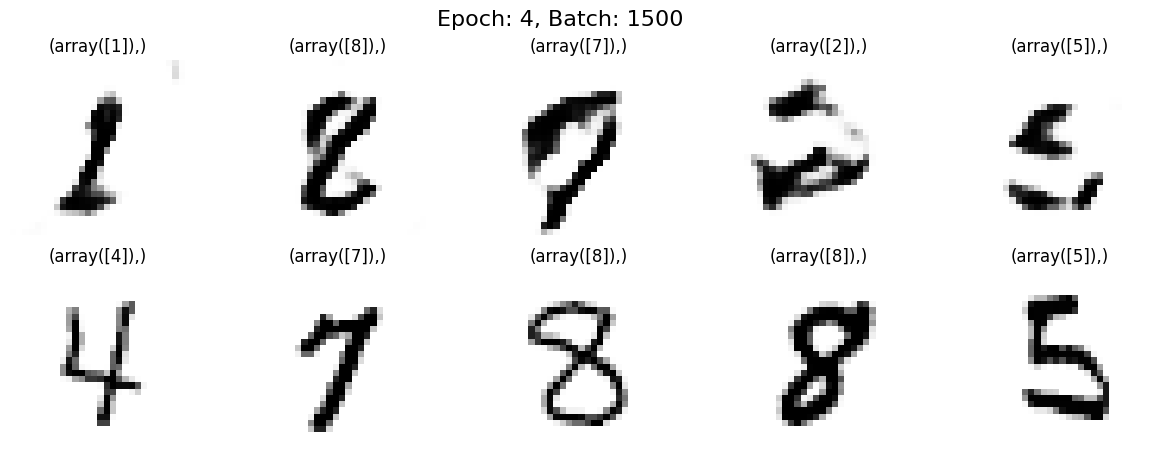

1550 [D loss: 0.7012,	 acc.: 57.81%]	[G loss: 0.7880]
1600 [D loss: 0.6856,	 acc.: 57.81%]	[G loss: 0.7219]
1650 [D loss: 0.6642,	 acc.: 65.62%]	[G loss: 0.8579]
1700 [D loss: 0.7011,	 acc.: 57.81%]	[G loss: 0.7431]
1750 [D loss: 0.7434,	 acc.: 50.00%]	[G loss: 0.7509]
1800 [D loss: 0.7425,	 acc.: 43.75%]	[G loss: 0.7072]
1850 [D loss: 0.6600,	 acc.: 65.62%]	[G loss: 0.7379]


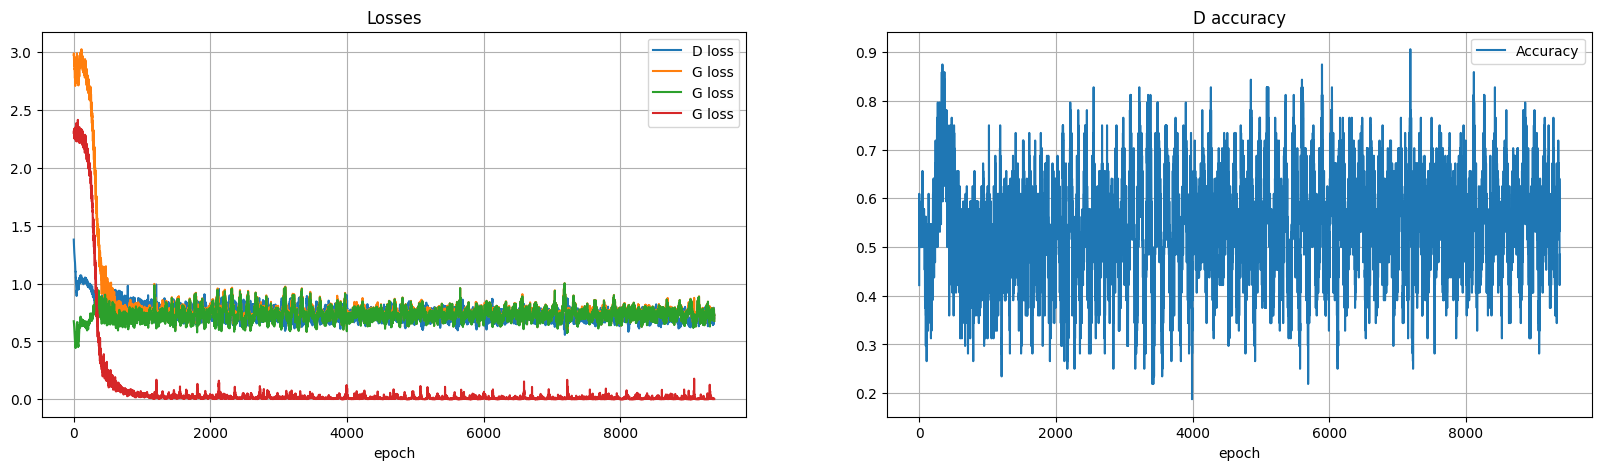

----EPOCH 5-----
0 [D loss: 0.6850,	 acc.: 60.94%]	[G loss: 0.7506]


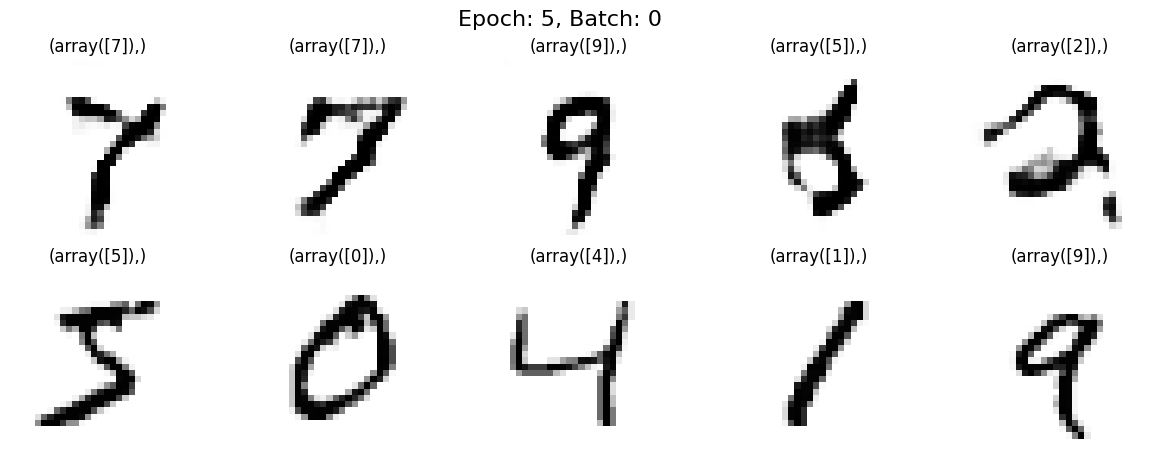

50 [D loss: 0.7047,	 acc.: 57.81%]	[G loss: 0.7572]
100 [D loss: 0.7115,	 acc.: 56.25%]	[G loss: 0.7658]
150 [D loss: 0.6699,	 acc.: 64.06%]	[G loss: 0.6987]
200 [D loss: 0.7361,	 acc.: 53.12%]	[G loss: 0.7078]
250 [D loss: 0.7395,	 acc.: 48.44%]	[G loss: 0.6906]
300 [D loss: 0.6769,	 acc.: 60.94%]	[G loss: 0.7054]
350 [D loss: 0.6913,	 acc.: 56.25%]	[G loss: 0.7273]
400 [D loss: 0.7051,	 acc.: 57.81%]	[G loss: 0.7361]
450 [D loss: 0.7390,	 acc.: 53.12%]	[G loss: 0.7011]
500 [D loss: 0.7183,	 acc.: 59.38%]	[G loss: 0.7499]


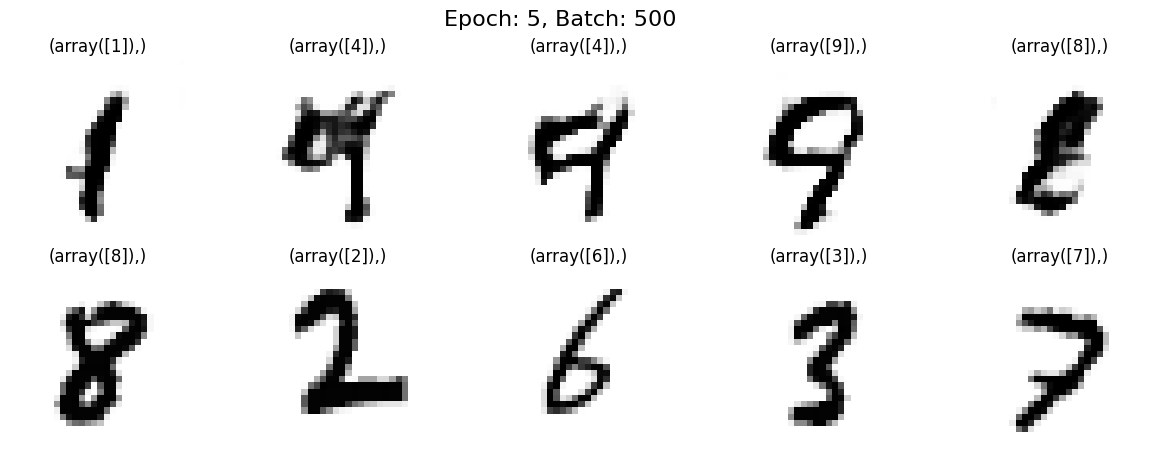

550 [D loss: 0.7013,	 acc.: 56.25%]	[G loss: 0.7734]
600 [D loss: 0.6722,	 acc.: 62.50%]	[G loss: 0.7602]
650 [D loss: 0.6859,	 acc.: 60.94%]	[G loss: 0.7453]
700 [D loss: 0.7230,	 acc.: 48.44%]	[G loss: 0.6773]
750 [D loss: 0.6793,	 acc.: 57.81%]	[G loss: 0.7278]
800 [D loss: 0.7286,	 acc.: 45.31%]	[G loss: 0.7082]
850 [D loss: 0.7429,	 acc.: 50.00%]	[G loss: 0.6928]
900 [D loss: 0.6914,	 acc.: 57.81%]	[G loss: 0.7191]
950 [D loss: 0.6958,	 acc.: 57.81%]	[G loss: 0.8071]
1000 [D loss: 0.7672,	 acc.: 45.31%]	[G loss: 0.7062]


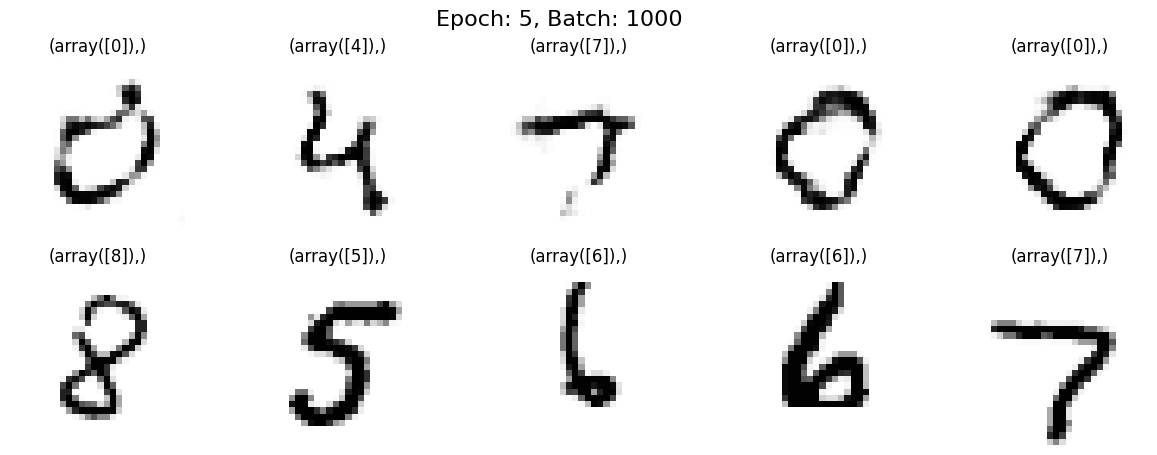

1050 [D loss: 0.7229,	 acc.: 48.44%]	[G loss: 0.7316]
1100 [D loss: 0.6819,	 acc.: 53.12%]	[G loss: 0.7972]
1150 [D loss: 0.7688,	 acc.: 40.62%]	[G loss: 0.6834]
1200 [D loss: 0.7199,	 acc.: 48.44%]	[G loss: 0.7591]
1250 [D loss: 0.7236,	 acc.: 56.25%]	[G loss: 0.8115]
1300 [D loss: 0.7379,	 acc.: 50.00%]	[G loss: 0.7133]
1350 [D loss: 0.6889,	 acc.: 64.06%]	[G loss: 0.7461]
1400 [D loss: 0.6657,	 acc.: 60.94%]	[G loss: 0.7468]
1450 [D loss: 0.7280,	 acc.: 50.00%]	[G loss: 0.7277]
1500 [D loss: 0.7177,	 acc.: 56.25%]	[G loss: 0.6921]


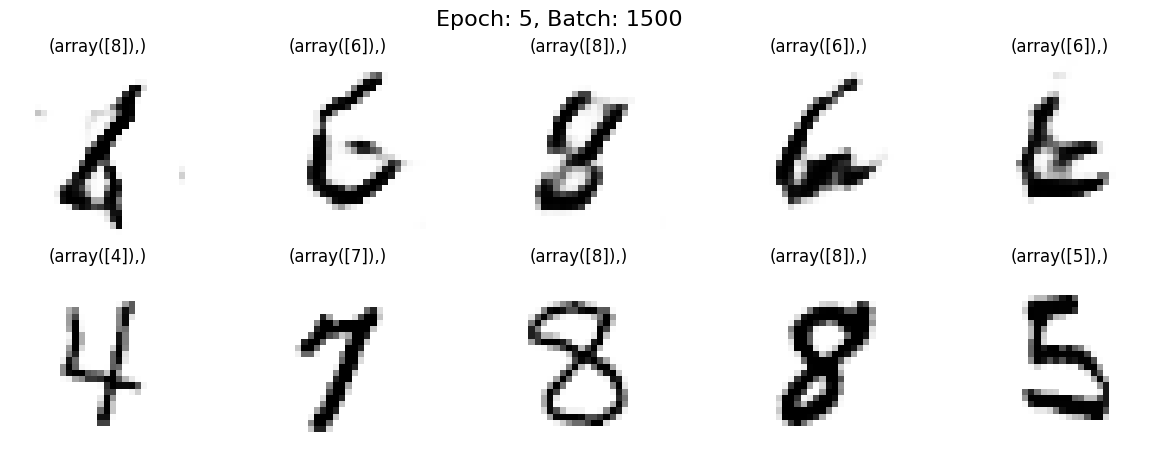

1550 [D loss: 0.6678,	 acc.: 67.19%]	[G loss: 0.8371]
1600 [D loss: 0.7744,	 acc.: 32.81%]	[G loss: 0.6572]
1650 [D loss: 0.6922,	 acc.: 65.62%]	[G loss: 0.7370]
1700 [D loss: 0.7245,	 acc.: 48.44%]	[G loss: 0.7070]
1750 [D loss: 0.6617,	 acc.: 65.62%]	[G loss: 0.6771]
1800 [D loss: 0.7298,	 acc.: 53.12%]	[G loss: 0.7662]
1850 [D loss: 0.7254,	 acc.: 46.88%]	[G loss: 0.6960]


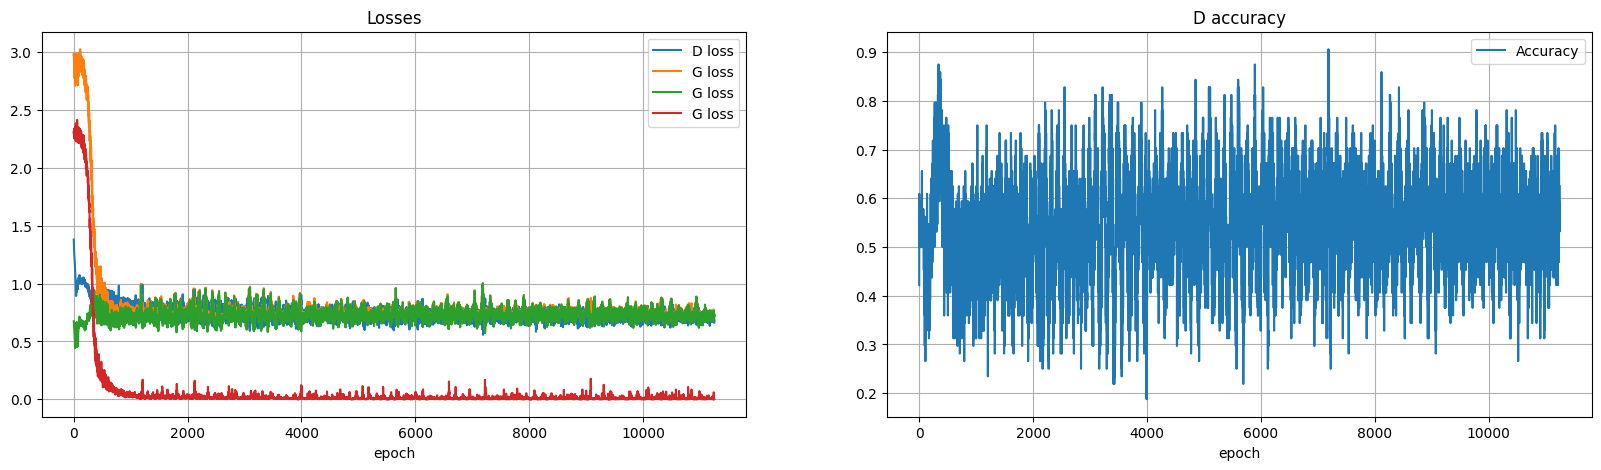

----EPOCH 6-----
0 [D loss: 0.7205,	 acc.: 51.56%]	[G loss: 0.7160]


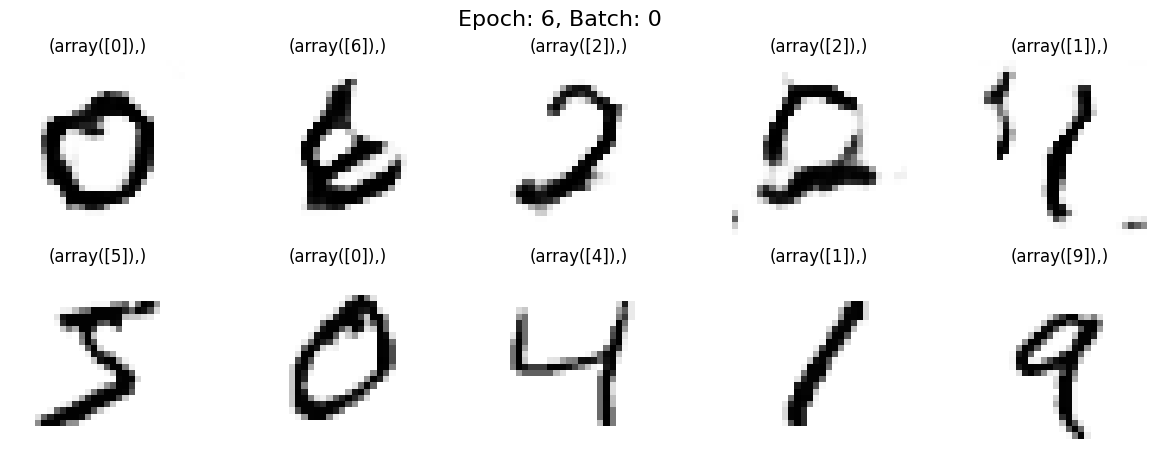

50 [D loss: 0.7338,	 acc.: 48.44%]	[G loss: 0.7545]
100 [D loss: 0.7208,	 acc.: 50.00%]	[G loss: 0.7248]
150 [D loss: 0.6882,	 acc.: 60.94%]	[G loss: 0.7338]
200 [D loss: 0.7204,	 acc.: 46.88%]	[G loss: 0.6938]
250 [D loss: 0.7210,	 acc.: 51.56%]	[G loss: 0.7549]
300 [D loss: 0.7208,	 acc.: 50.00%]	[G loss: 0.6825]
350 [D loss: 0.6958,	 acc.: 67.19%]	[G loss: 0.7754]
400 [D loss: 0.6851,	 acc.: 57.81%]	[G loss: 0.7144]
450 [D loss: 0.7190,	 acc.: 46.88%]	[G loss: 0.6632]
500 [D loss: 0.6920,	 acc.: 60.94%]	[G loss: 0.7499]


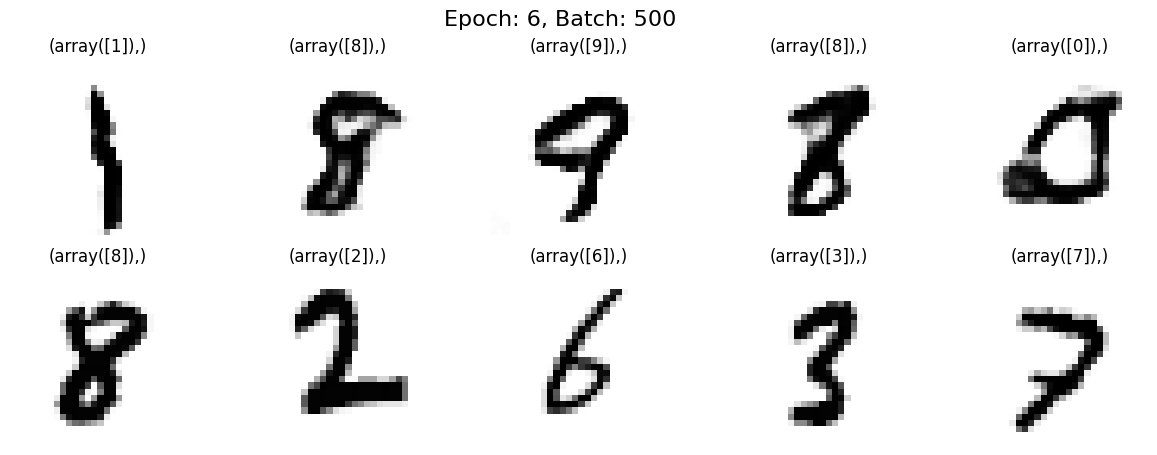

550 [D loss: 0.6903,	 acc.: 59.38%]	[G loss: 0.6983]
600 [D loss: 0.7022,	 acc.: 54.69%]	[G loss: 0.7569]
650 [D loss: 0.7044,	 acc.: 50.00%]	[G loss: 0.6891]
700 [D loss: 0.6574,	 acc.: 68.75%]	[G loss: 0.7530]
750 [D loss: 0.6682,	 acc.: 67.19%]	[G loss: 0.6812]
800 [D loss: 0.7053,	 acc.: 50.00%]	[G loss: 0.6831]
850 [D loss: 0.6880,	 acc.: 59.38%]	[G loss: 0.8132]
900 [D loss: 0.7083,	 acc.: 51.56%]	[G loss: 0.7105]
950 [D loss: 0.6917,	 acc.: 56.25%]	[G loss: 0.7172]
1000 [D loss: 0.7007,	 acc.: 60.94%]	[G loss: 0.7649]


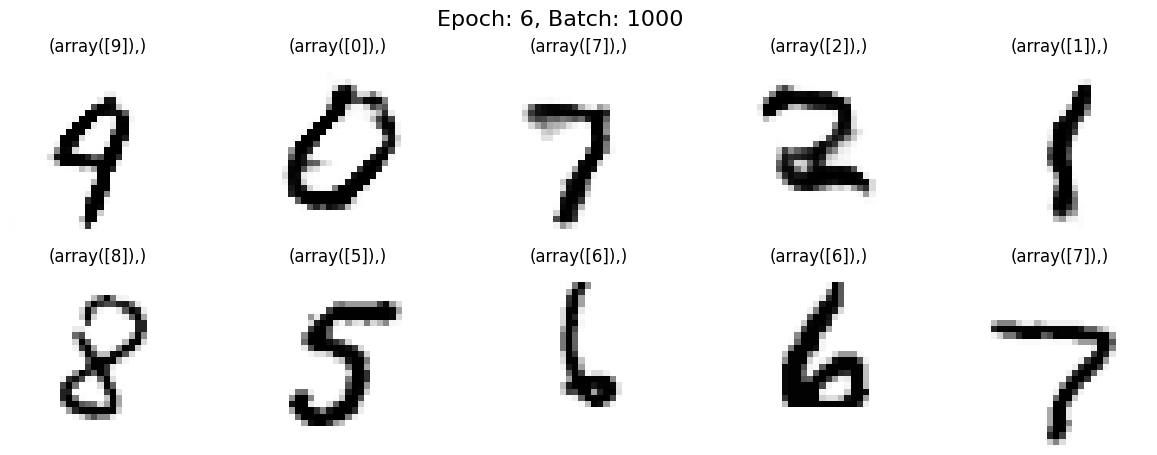

1050 [D loss: 0.6853,	 acc.: 67.19%]	[G loss: 0.7012]
1100 [D loss: 0.7067,	 acc.: 54.69%]	[G loss: 0.7314]
1150 [D loss: 0.6993,	 acc.: 57.81%]	[G loss: 0.7747]
1200 [D loss: 0.7083,	 acc.: 48.44%]	[G loss: 0.7151]
1250 [D loss: 0.7048,	 acc.: 53.12%]	[G loss: 0.7103]
1300 [D loss: 0.6882,	 acc.: 59.38%]	[G loss: 0.7290]
1350 [D loss: 0.7353,	 acc.: 43.75%]	[G loss: 0.7100]
1400 [D loss: 0.7013,	 acc.: 56.25%]	[G loss: 0.7206]
1450 [D loss: 0.7542,	 acc.: 39.06%]	[G loss: 0.7305]
1500 [D loss: 0.7081,	 acc.: 54.69%]	[G loss: 0.7309]


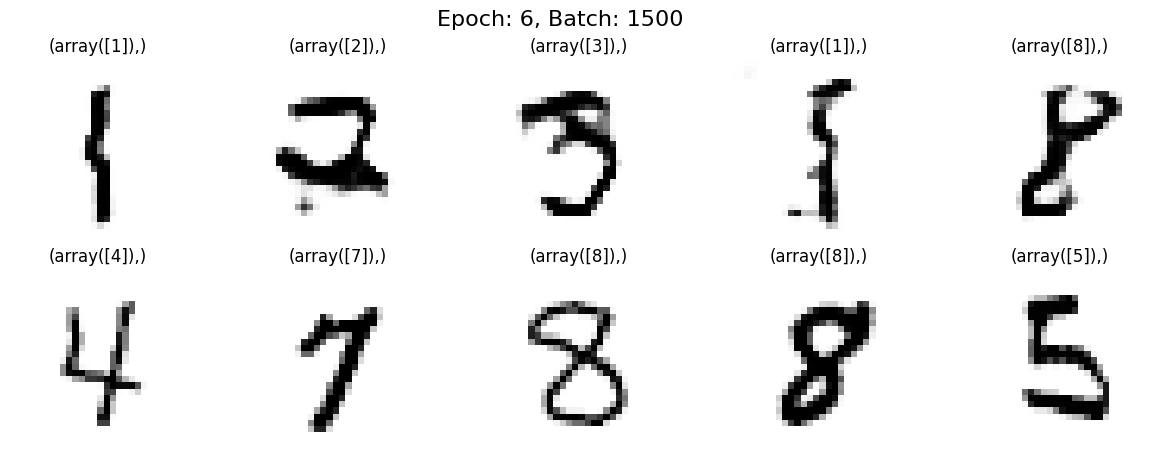

1550 [D loss: 0.6808,	 acc.: 60.94%]	[G loss: 0.7425]
1600 [D loss: 0.6921,	 acc.: 50.00%]	[G loss: 0.6982]
1650 [D loss: 0.7031,	 acc.: 62.50%]	[G loss: 0.7373]
1700 [D loss: 0.7149,	 acc.: 51.56%]	[G loss: 0.7363]
1750 [D loss: 0.6897,	 acc.: 57.81%]	[G loss: 0.6934]
1800 [D loss: 0.6825,	 acc.: 59.38%]	[G loss: 0.8424]
1850 [D loss: 0.7439,	 acc.: 29.69%]	[G loss: 0.6680]


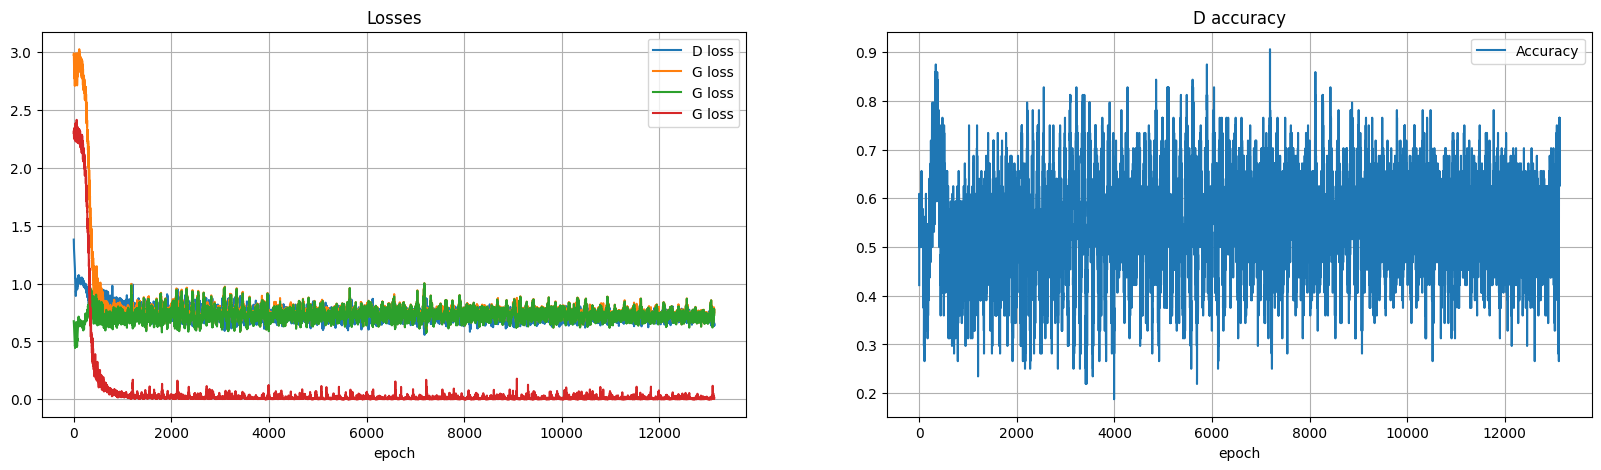

----EPOCH 7-----
0 [D loss: 0.6605,	 acc.: 64.06%]	[G loss: 0.7586]


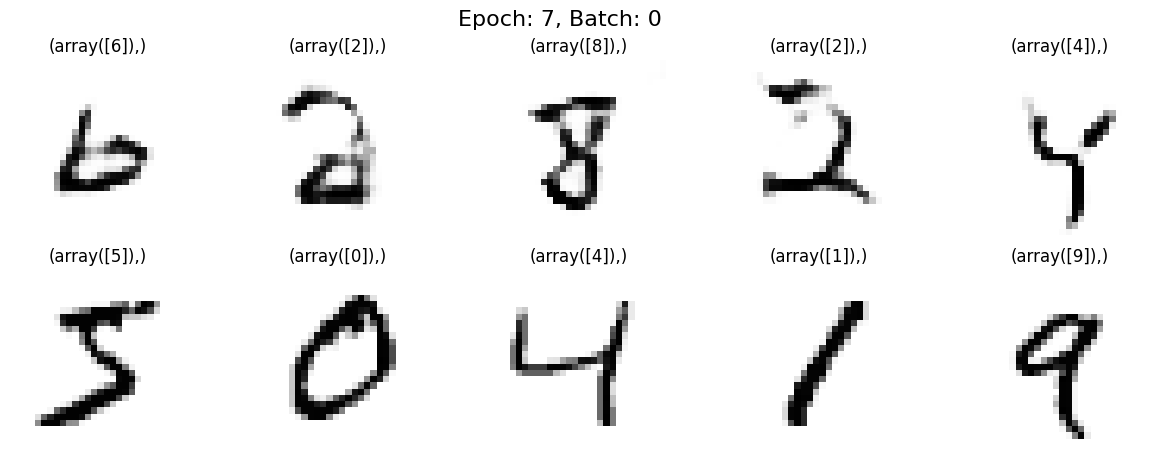

50 [D loss: 0.7477,	 acc.: 35.94%]	[G loss: 0.7307]
100 [D loss: 0.7159,	 acc.: 57.81%]	[G loss: 0.7681]
150 [D loss: 0.7006,	 acc.: 64.06%]	[G loss: 0.7369]
200 [D loss: 0.7210,	 acc.: 53.12%]	[G loss: 0.7061]
250 [D loss: 0.7235,	 acc.: 53.12%]	[G loss: 0.8059]
300 [D loss: 0.7266,	 acc.: 53.12%]	[G loss: 0.6854]
350 [D loss: 0.6619,	 acc.: 67.19%]	[G loss: 0.6985]
400 [D loss: 0.7311,	 acc.: 32.81%]	[G loss: 0.7141]
450 [D loss: 0.7440,	 acc.: 45.31%]	[G loss: 0.7714]
500 [D loss: 0.6895,	 acc.: 65.62%]	[G loss: 0.7197]


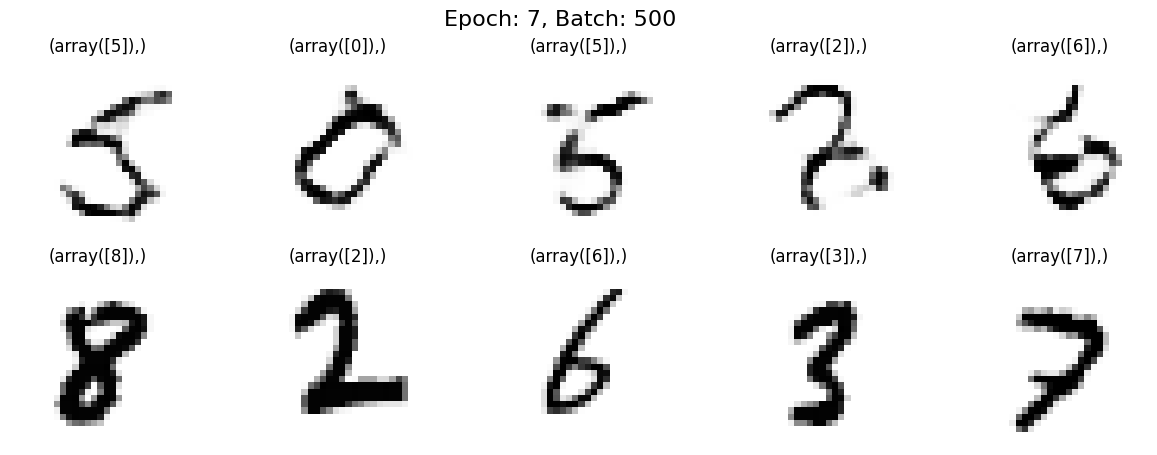

550 [D loss: 0.7056,	 acc.: 50.00%]	[G loss: 0.6796]
600 [D loss: 0.7128,	 acc.: 59.38%]	[G loss: 0.7568]
650 [D loss: 0.6910,	 acc.: 59.38%]	[G loss: 0.7839]
700 [D loss: 0.6982,	 acc.: 54.69%]	[G loss: 0.6993]
750 [D loss: 0.6869,	 acc.: 56.25%]	[G loss: 0.7512]
800 [D loss: 0.7368,	 acc.: 43.75%]	[G loss: 0.7003]
850 [D loss: 0.6992,	 acc.: 56.25%]	[G loss: 0.6908]
900 [D loss: 0.7119,	 acc.: 46.88%]	[G loss: 0.6903]
950 [D loss: 0.7297,	 acc.: 51.56%]	[G loss: 0.7731]
1000 [D loss: 0.7108,	 acc.: 56.25%]	[G loss: 0.7585]


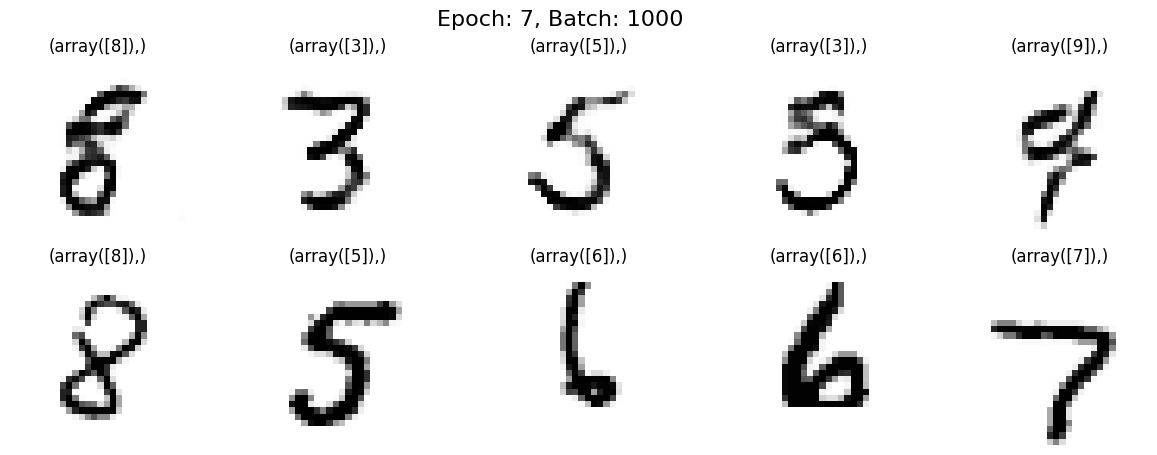

1050 [D loss: 0.6983,	 acc.: 56.25%]	[G loss: 0.7561]
1100 [D loss: 0.7260,	 acc.: 51.56%]	[G loss: 0.7167]
1150 [D loss: 0.7145,	 acc.: 45.31%]	[G loss: 0.7029]
1200 [D loss: 0.6579,	 acc.: 65.62%]	[G loss: 0.6875]
1250 [D loss: 0.7358,	 acc.: 37.50%]	[G loss: 0.7117]
1300 [D loss: 0.7128,	 acc.: 50.00%]	[G loss: 0.7153]
1350 [D loss: 0.7063,	 acc.: 64.06%]	[G loss: 0.6819]
1400 [D loss: 0.6945,	 acc.: 51.56%]	[G loss: 0.7430]
1450 [D loss: 0.7053,	 acc.: 43.75%]	[G loss: 0.7328]
1500 [D loss: 0.7020,	 acc.: 39.06%]	[G loss: 0.7072]


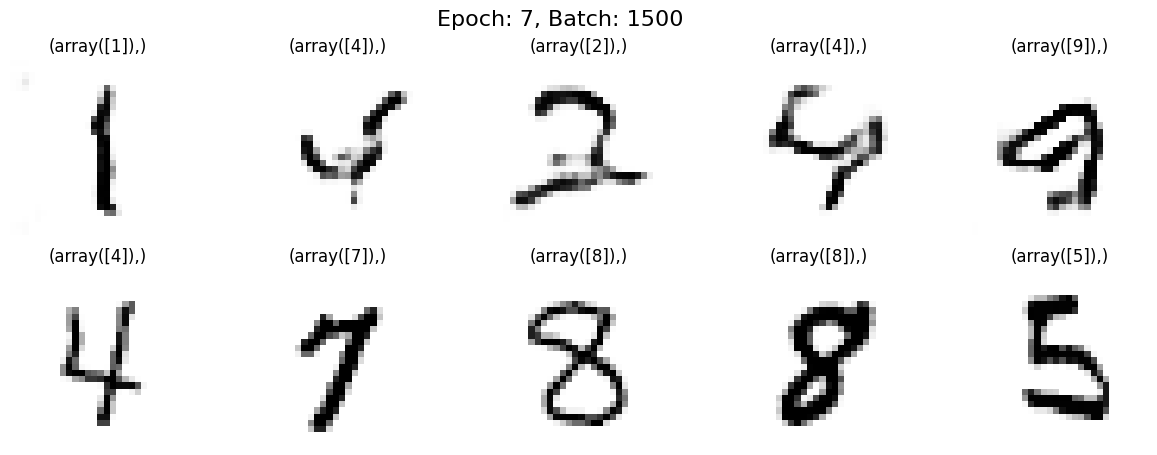

1550 [D loss: 0.7008,	 acc.: 59.38%]	[G loss: 0.7299]
1600 [D loss: 0.7074,	 acc.: 56.25%]	[G loss: 0.7354]
1650 [D loss: 0.6780,	 acc.: 65.62%]	[G loss: 0.7363]
1700 [D loss: 0.7464,	 acc.: 40.62%]	[G loss: 0.6586]
1750 [D loss: 0.7123,	 acc.: 54.69%]	[G loss: 0.6972]
1800 [D loss: 0.7368,	 acc.: 40.62%]	[G loss: 0.7378]
1850 [D loss: 0.6770,	 acc.: 64.06%]	[G loss: 0.7155]


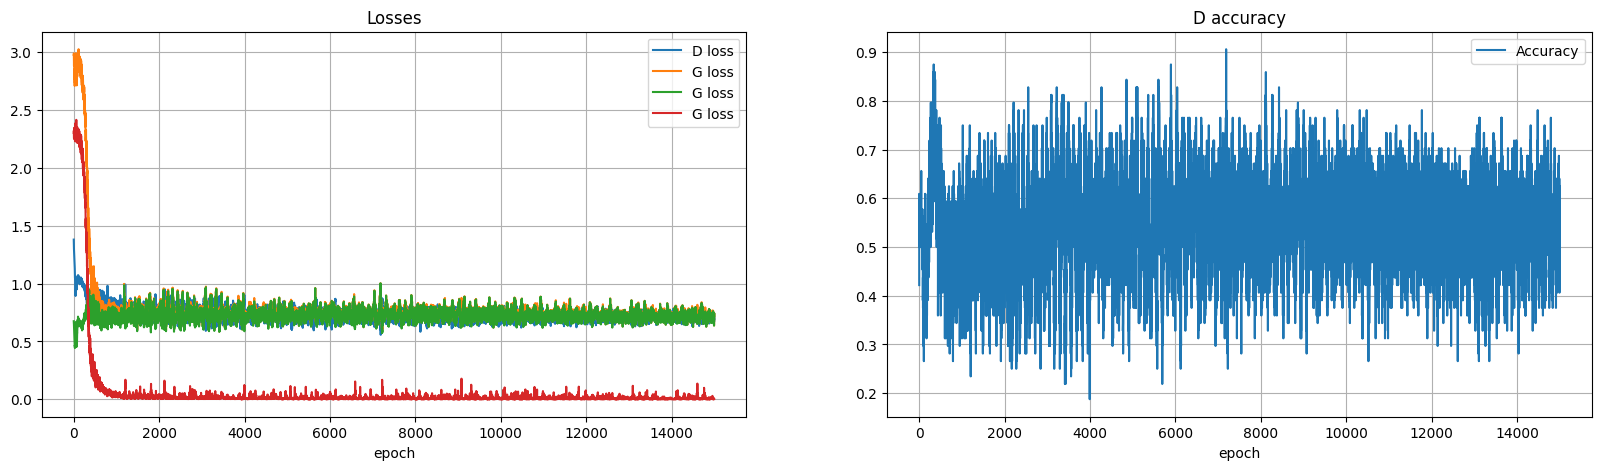

----EPOCH 8-----
0 [D loss: 0.7087,	 acc.: 46.88%]	[G loss: 0.6710]


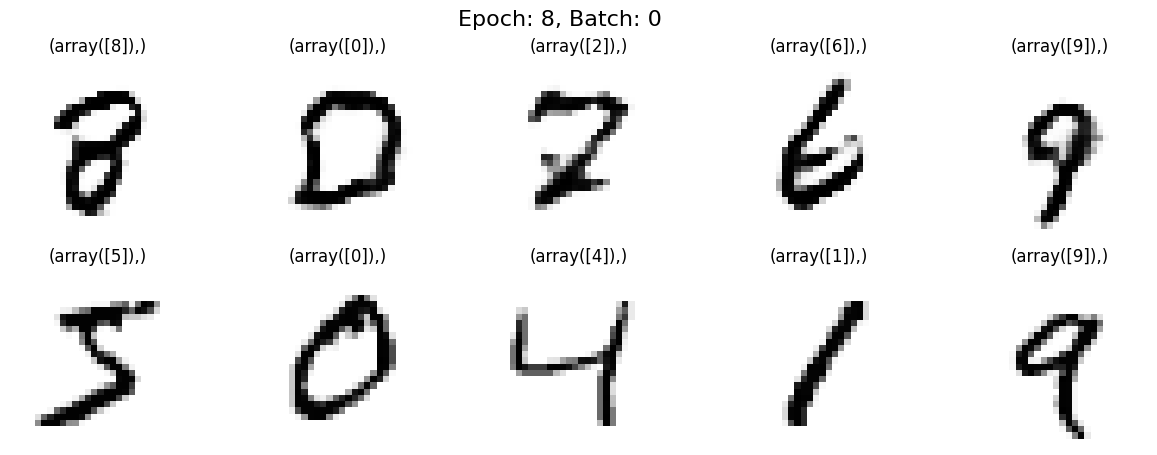

50 [D loss: 0.7081,	 acc.: 46.88%]	[G loss: 0.7815]
100 [D loss: 0.6933,	 acc.: 54.69%]	[G loss: 0.7631]
150 [D loss: 0.6775,	 acc.: 62.50%]	[G loss: 0.7014]
200 [D loss: 0.7217,	 acc.: 46.88%]	[G loss: 0.6707]
250 [D loss: 0.6955,	 acc.: 57.81%]	[G loss: 0.8047]
300 [D loss: 0.7111,	 acc.: 53.12%]	[G loss: 0.6897]
350 [D loss: 0.7362,	 acc.: 45.31%]	[G loss: 0.6953]
400 [D loss: 0.6678,	 acc.: 56.25%]	[G loss: 0.8105]
450 [D loss: 0.7237,	 acc.: 43.75%]	[G loss: 0.7173]
500 [D loss: 0.7486,	 acc.: 45.31%]	[G loss: 0.7181]


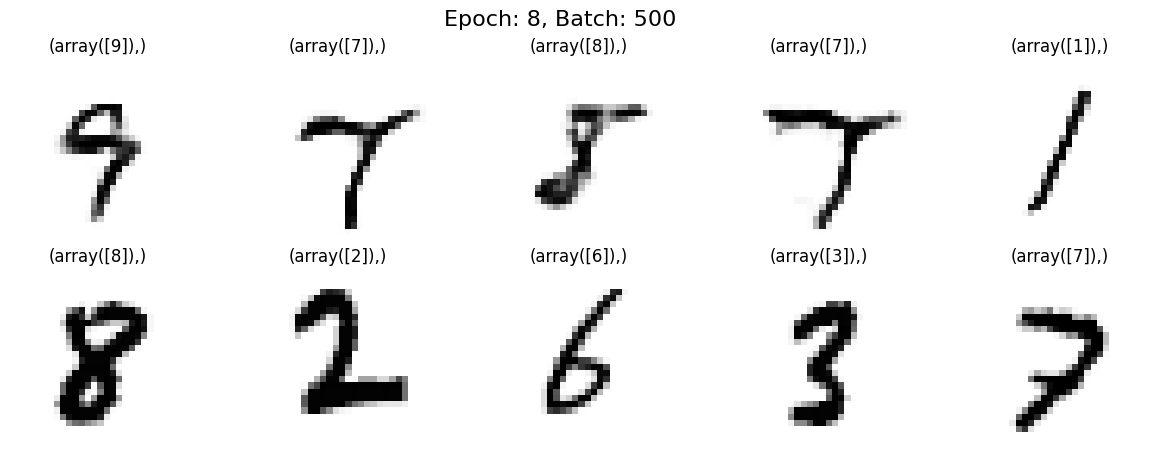

550 [D loss: 0.7061,	 acc.: 46.88%]	[G loss: 0.6894]
600 [D loss: 0.7183,	 acc.: 59.38%]	[G loss: 0.7773]
650 [D loss: 0.7178,	 acc.: 46.88%]	[G loss: 0.6764]
700 [D loss: 0.7241,	 acc.: 48.44%]	[G loss: 0.6951]
750 [D loss: 0.7018,	 acc.: 60.94%]	[G loss: 0.7452]
800 [D loss: 0.7244,	 acc.: 50.00%]	[G loss: 0.6675]
850 [D loss: 0.6962,	 acc.: 62.50%]	[G loss: 0.6953]
900 [D loss: 0.7039,	 acc.: 53.12%]	[G loss: 0.7329]
950 [D loss: 0.6997,	 acc.: 50.00%]	[G loss: 0.7332]
1000 [D loss: 0.7396,	 acc.: 39.06%]	[G loss: 0.6931]


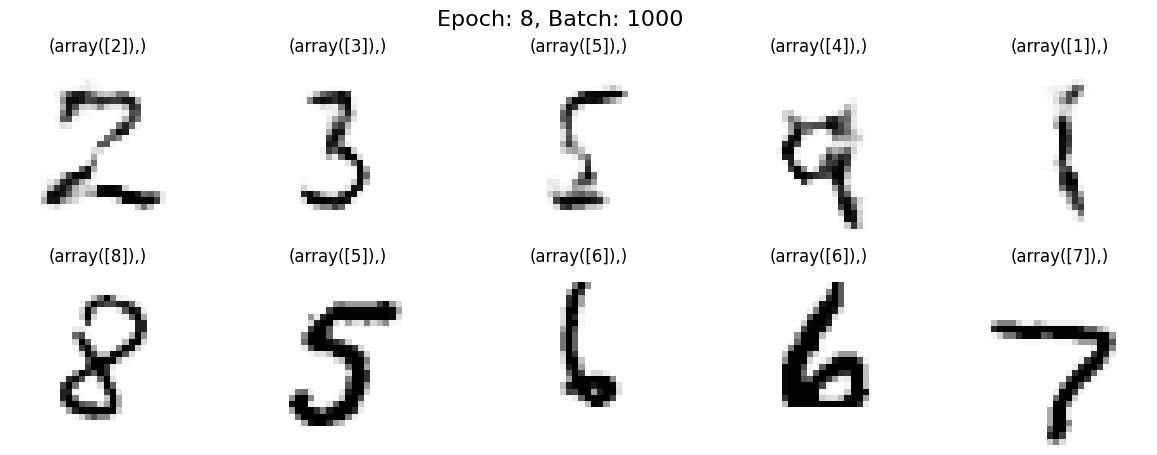

1050 [D loss: 0.7120,	 acc.: 51.56%]	[G loss: 0.6867]
1100 [D loss: 0.7370,	 acc.: 51.56%]	[G loss: 0.7277]
1150 [D loss: 0.7390,	 acc.: 42.19%]	[G loss: 0.7066]
1200 [D loss: 0.6546,	 acc.: 71.88%]	[G loss: 0.7156]
1250 [D loss: 0.7078,	 acc.: 50.00%]	[G loss: 0.7084]
1300 [D loss: 0.7234,	 acc.: 45.31%]	[G loss: 0.6961]
1350 [D loss: 0.7135,	 acc.: 50.00%]	[G loss: 0.7270]
1400 [D loss: 0.6905,	 acc.: 46.88%]	[G loss: 0.6954]
1450 [D loss: 0.7036,	 acc.: 51.56%]	[G loss: 0.7512]
1500 [D loss: 0.7230,	 acc.: 42.19%]	[G loss: 0.6762]


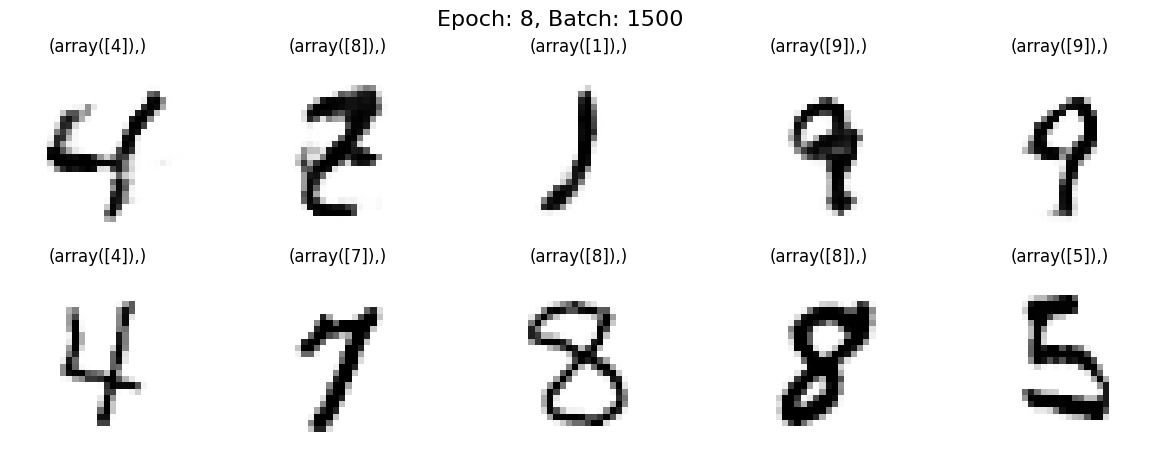

1550 [D loss: 0.6892,	 acc.: 54.69%]	[G loss: 0.7197]
1600 [D loss: 0.7142,	 acc.: 50.00%]	[G loss: 0.7583]
1650 [D loss: 0.6925,	 acc.: 64.06%]	[G loss: 0.6846]
1700 [D loss: 0.7290,	 acc.: 43.75%]	[G loss: 0.6960]
1750 [D loss: 0.6926,	 acc.: 56.25%]	[G loss: 0.6814]
1800 [D loss: 0.6758,	 acc.: 64.06%]	[G loss: 0.7502]
1850 [D loss: 0.7070,	 acc.: 56.25%]	[G loss: 0.6957]


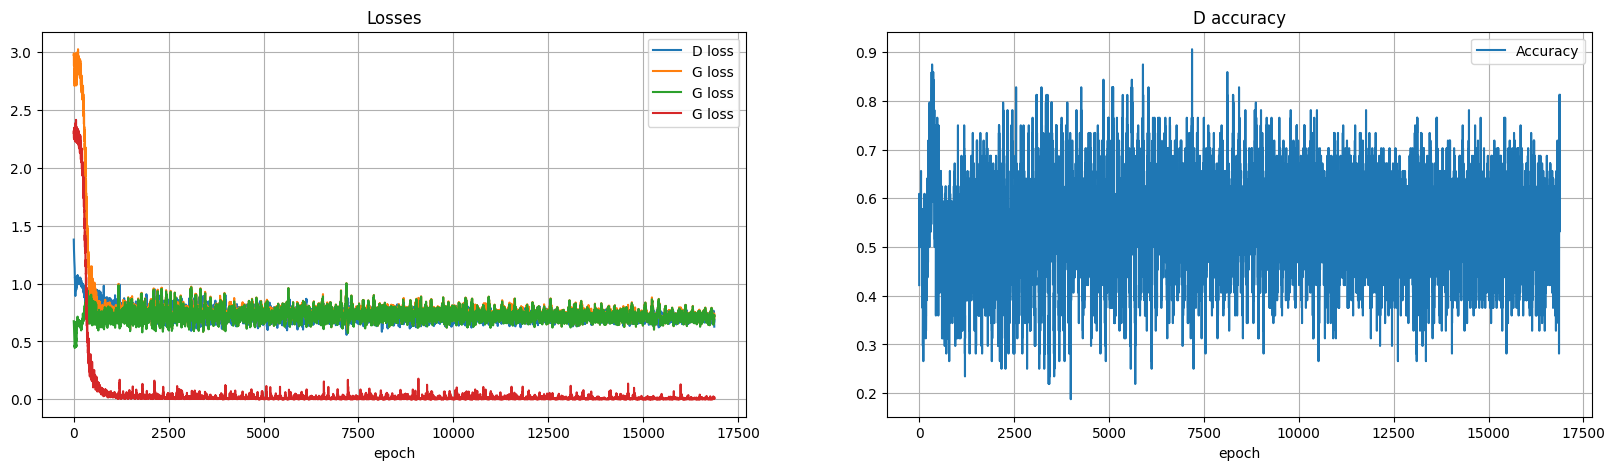

----EPOCH 9-----
0 [D loss: 0.6968,	 acc.: 57.81%]	[G loss: 0.7013]


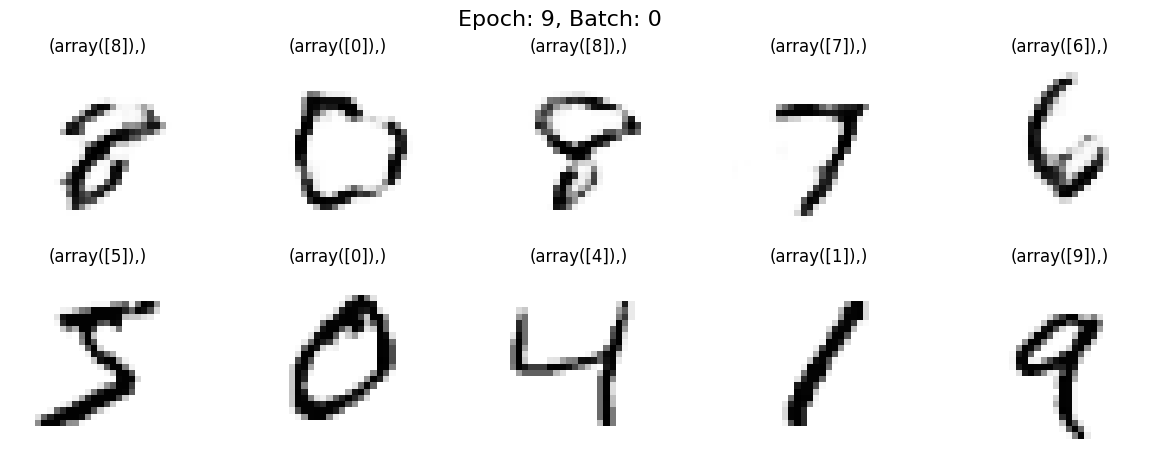

50 [D loss: 0.7248,	 acc.: 45.31%]	[G loss: 0.7050]
100 [D loss: 0.6789,	 acc.: 57.81%]	[G loss: 0.7628]
150 [D loss: 0.7247,	 acc.: 50.00%]	[G loss: 0.6625]
200 [D loss: 0.6973,	 acc.: 50.00%]	[G loss: 0.6715]
250 [D loss: 0.6873,	 acc.: 59.38%]	[G loss: 0.7748]
300 [D loss: 0.6731,	 acc.: 53.12%]	[G loss: 0.7256]
350 [D loss: 0.6992,	 acc.: 53.12%]	[G loss: 0.7179]
400 [D loss: 0.7208,	 acc.: 45.31%]	[G loss: 0.7095]
450 [D loss: 0.7100,	 acc.: 53.12%]	[G loss: 0.7639]
500 [D loss: 0.7067,	 acc.: 60.94%]	[G loss: 0.6999]


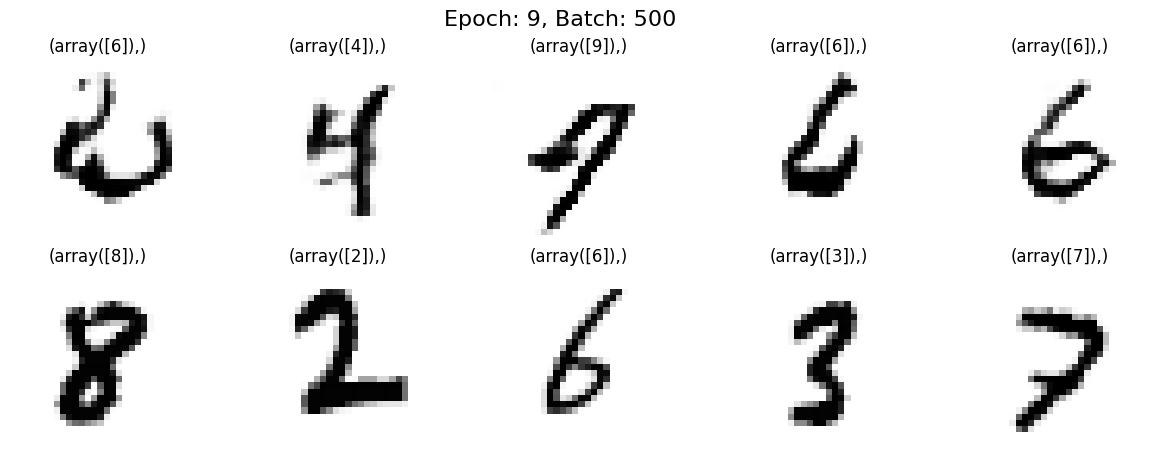

550 [D loss: 0.7144,	 acc.: 45.31%]	[G loss: 0.6571]
600 [D loss: 0.6925,	 acc.: 56.25%]	[G loss: 0.6903]
650 [D loss: 0.6964,	 acc.: 48.44%]	[G loss: 0.7687]
700 [D loss: 0.7152,	 acc.: 48.44%]	[G loss: 0.7010]
750 [D loss: 0.6843,	 acc.: 51.56%]	[G loss: 0.7289]
800 [D loss: 0.7063,	 acc.: 53.12%]	[G loss: 0.6911]
850 [D loss: 0.6974,	 acc.: 48.44%]	[G loss: 0.7644]
900 [D loss: 0.6898,	 acc.: 54.69%]	[G loss: 0.6728]
950 [D loss: 0.7023,	 acc.: 53.12%]	[G loss: 0.7045]
1000 [D loss: 0.7163,	 acc.: 50.00%]	[G loss: 0.7274]


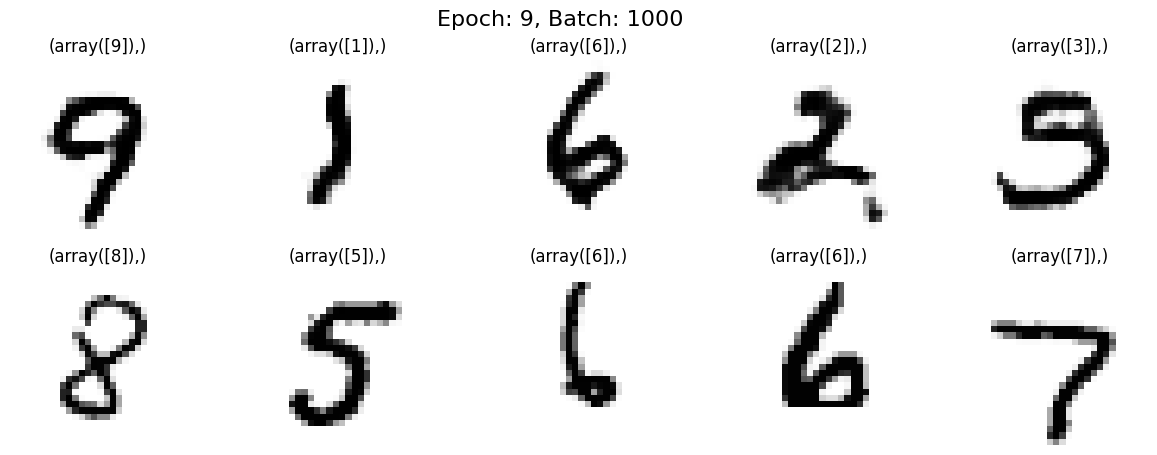

1050 [D loss: 0.7080,	 acc.: 51.56%]	[G loss: 0.7215]
1100 [D loss: 0.6980,	 acc.: 56.25%]	[G loss: 0.6954]
1150 [D loss: 0.6955,	 acc.: 59.38%]	[G loss: 0.6995]
1200 [D loss: 0.6957,	 acc.: 60.94%]	[G loss: 0.7540]
1250 [D loss: 0.7053,	 acc.: 59.38%]	[G loss: 0.7137]
1300 [D loss: 0.7056,	 acc.: 51.56%]	[G loss: 0.6965]
1350 [D loss: 0.7114,	 acc.: 43.75%]	[G loss: 0.7167]
1400 [D loss: 0.6769,	 acc.: 56.25%]	[G loss: 0.7206]
1450 [D loss: 0.7059,	 acc.: 59.38%]	[G loss: 0.6888]
1500 [D loss: 0.6924,	 acc.: 60.94%]	[G loss: 0.7259]


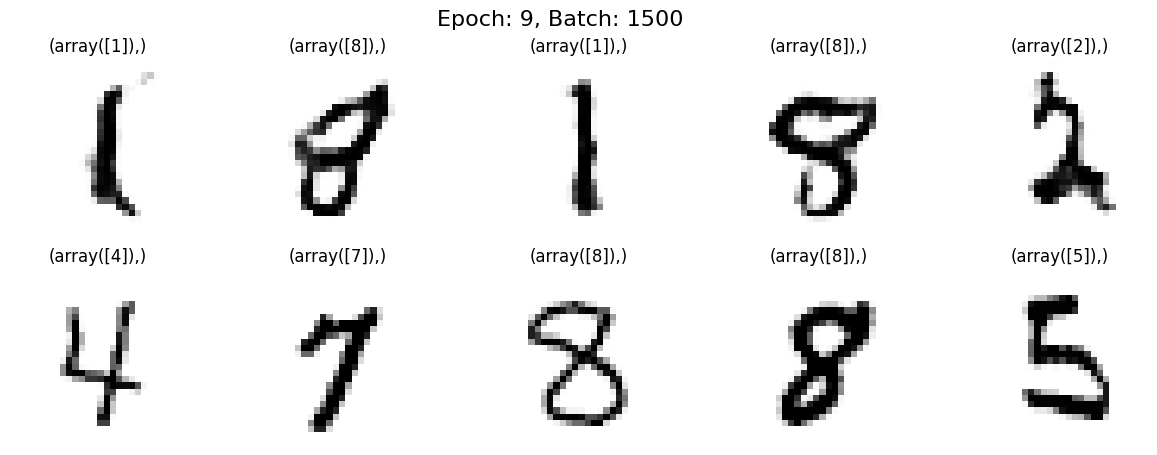

1550 [D loss: 0.6750,	 acc.: 60.94%]	[G loss: 0.7462]
1600 [D loss: 0.7411,	 acc.: 34.38%]	[G loss: 0.6715]
1650 [D loss: 0.7040,	 acc.: 54.69%]	[G loss: 0.6661]
1700 [D loss: 0.7121,	 acc.: 50.00%]	[G loss: 0.7149]
1750 [D loss: 0.6981,	 acc.: 57.81%]	[G loss: 0.7107]
1800 [D loss: 0.7017,	 acc.: 53.12%]	[G loss: 0.6927]
1850 [D loss: 0.6807,	 acc.: 62.50%]	[G loss: 0.7033]


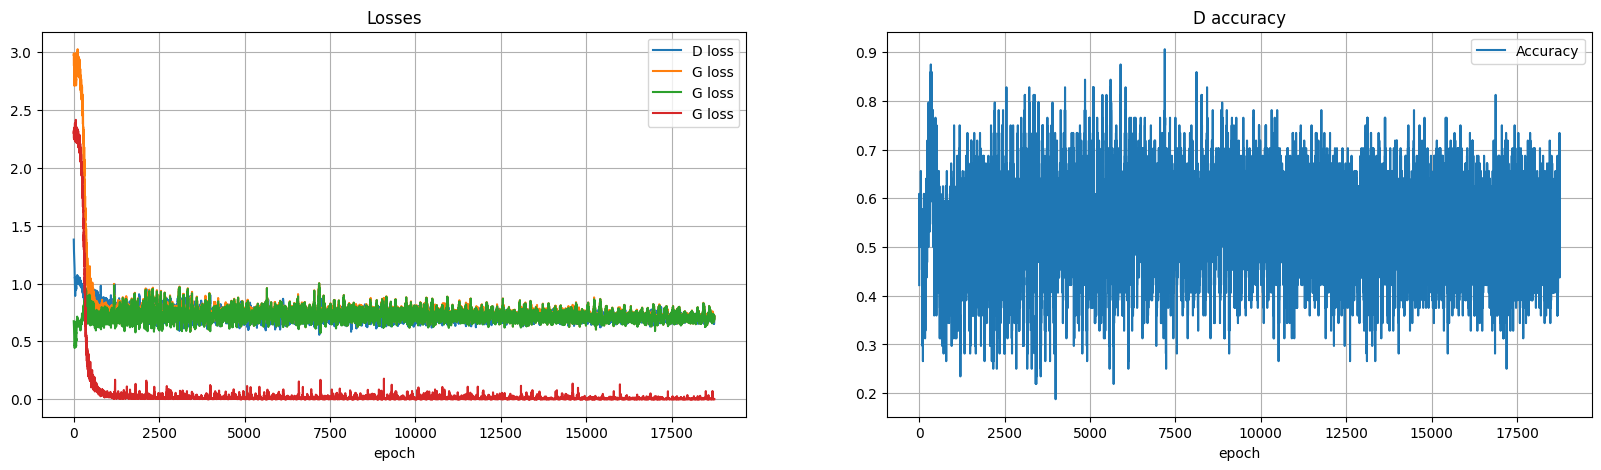

In [13]:
train(X_train, y_train, generator, discriminator, combined, epochs=10, batch_size=32, sample_interval=100)

---

Creado por **Guillermo Iglesias** (guillermo.iglesias@upm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">